<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.878 · Trabajo fin de Máster · PEC3</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Fase 3. Selección y evaluación de modelos predictivos

Este notebook está dividido en las siguientes partes:
    
1. Introducción
2. Selección de caracteristicas
3. Generación de modelos basado en métodos de resampling
4. Generación de modelos basados en métodos de ensamble
5. Generación de modelos basados en Cost-sensitive learning
6. Generación de modelo predictivo basado en voting
7. Resumen métricas modelos predictivos
8. Importancia caracteristicas
9. Conclusiones

# 1. Introducción

En el presente notebook se desarrolla la tercer y última fase de la PEC 3 del trabajo de fin de máster titulado: **Técnicas de aprendizaje automático aplicadas en la predicción de potenciales compradores en un e-commerce de productos empresariales en Colombia**.
En la sección 2 se realiza el proceso de selección de características. Para ello se determinó el mejor modelo de ensamble referencia (que tienen integrado funcionalidades de ranking de características) y sobre este se aplicó la técnica RFE (Recursive Feature Elimination), para seleccionar las variables más relevantes. En la sección 3 se desarrolla el primer método para la generación de modelos predictivos. Dicho método se conoce como remuestreo, el cual tiene diferentes técnicas que permite balancear las clases de la variable objetivo. Para determinar las mejores técnicas, en primer lugar, se seleccionan los mejores modelos de clasificación. Luego a los mejores modelos se les aplica diferentes métodos de remuestreo. Sobre los mejores modelos obtenidos se optimiza hiperparámetros, entrenan y evalúan. En la sección 4 se desarrolla el segundo método de generación de modelos predictivos basado en ensamble. Para ello se determinan los mejores modelos y posteriormente se optimiza hiperparámetros, entrenan y evalúan. En la sección 5 se aplica el tercer y último método para generar modelos predictivos que se basa en el concepto de Cost-sensitive learning (CSL). En este caso se usaron los modelos de ensamble que obtuvieron el mejor desempeño en la sección 2 y que tienen integrado la funcionalidad (CSL). Posteriormente en la sección 6, se generan un modelo final basado en la técnica de voting, donde se incluyen los modelos que mejor se desempeñaron en las secciones anteriores. En la sección 7 se hace un consolidado de las métricas más relevantes de los modelos obtenidos y su respectivo análisis. Finalmente, la Sección 9 recoge las conclusiones más significativas derivadas del estudio realizado en este notebook

In [25]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import etl_process as etl    
import model_prediction as mpd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (GradientBoostingClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, RandomForestClassifier, 
                              BaggingClassifier)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import (train_test_split, RepeatedStratifiedKFold, 
                                     cross_val_predict, cross_val_score)
from sklearn.metrics import (roc_auc_score, precision_score, 
                             recall_score, f1_score, accuracy_score,
                             confusion_matrix, make_scorer)

from imblearn.over_sampling import (RandomOverSampler, SMOTE,
                                    BorderlineSMOTE, SVMSMOTE, ADASYN)
from imblearn.under_sampling import (RandomUnderSampler, AllKNN,  CondensedNearestNeighbour)
from imblearn.combine import SMOTETomek, SMOTEENN

from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score

from imblearn.ensemble import (
    RUSBoostClassifier,
    EasyEnsembleClassifier,
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier
)

from imbens.ensemble import (
    OverBoostClassifier,
    SMOTEBoostClassifier,
    OverBaggingClassifier,
    SMOTEBaggingClassifier
)

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from joblib import dump

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle

primary_metric = 'f1_macro'
seed = 123
n_jobs=6

primary_eval_metric = [f1_score, precision_score, recall_score]
display_scores=[primary_eval_metric]
confusion_labels = ['0', '1']

# 2. Selección de caracteristicas

Con el propósito de identificar las variables que aporte mayor poder predictivo en la fase de entrenamiento de los modelos, se realizó el proceso de selección de característica, el cual se llevó a cabo mediante las siguientes etapas. 
    
- En primer lugar, se definió le métrica con la que se entrenarán los modelos. En vista que el problema que se quiere resolver es un problema de clasificación, donde la variable objetivo está altamente desbalanceada se decidió utilizar la f1_macro como métrica de entrenamiento. 
Su elección se justica dado que al entrenar modelos en datos desbalanceados  trata todas las clases por igual, promoviendo un rendimiento equilibrado y previniendo el sesgo hacia la clase mayoritaria. Al calcular el promedio no ponderado de los F1-scores de todas las clases, asegura que el modelo mantenga un buen balance entre precisión y recall para cada clase, incluida la minoritaria, que es crucial para aplicaciones donde es importante no pasar por alto ningún caso positivo.


- En segundo lugar, se entrenaron modelos de referencia con sus parámetros por defecto para determinar cual tiene mejor desempeño. Se identifico el mejor modelo basado en la resultados de la f1_macro obtenida en el conjunto de entrenamiento y validación del dataset inicial. Posteriormente sobre este modelo se aplicó la técnica RFE (Recursive feature elimination) para realizar la selección de características.


In [51]:
data_set = pd.read_pickle('data//data_set_2.pkl')

In [52]:
X = data_set.select_dtypes(include=['int', 'float'])
y = data_set.loc[:, 'usu_ind_cliente']

In [53]:
X.drop(['usu_ind_cliente'], axis=1, inplace=True)

In [54]:
X.reset_index(drop=True, inplace=True)
y = LabelEncoder().fit_transform(y.values.ravel())

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [56]:
mixmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

X_train = mixmax_scaler.fit(X_train).transform(X_train)
X_test = mixmax_scaler.fit(X_test).transform(X_test)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.fit_transform(X_test)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(99915, 20)
(42821, 20)
(99915,)
(42821,)


In [9]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def get_models():
    """
    Devuelve una lista de modelos de clasificación y sus nombres asociados.

    Salida:
    - Una tupla que contiene dos listas:
      1. Una lista de modelos de clasificación (instancias de los clasificadores).
      2. Una lista de nombres asociados a cada modelo.
    """
    models, names = list(), list()
    # GBM
    models.append(GradientBoostingClassifier())
    names.append('GBM')       
    # RF
    models.append(RandomForestClassifier())
    names.append('RF')                
    # LGBM
    models.append(LGBMClassifier())
    names.append('LGBM')
    # XGB
    models.append(XGBClassifier())
    names.append('XGB')

    return models, names

In [10]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def evaluate_model(X, y, model):
    """
    Evalúa el rendimiento de un modelo de clasificación utilizando validación cruzada con selección de características.

    Parámetros:
    - X (array-like): Matriz de características de entrada.
    - y (array-like): Vector de etiquetas de clase correspondiente a las características.
    - model: Modelo de clasificación a evaluar.
    
    Salida:
    - Una lista de puntajes de rendimiento del modelo en diferentes particiones de validación cruzada.    
    """
    rfe = RFECV(estimator=model)
    pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    scores = cross_val_score(pipeline, X, y, scoring=primary_metric, cv=cv, n_jobs=n_jobs, error_score='raise')
    return scores

In [11]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

models, names = get_models()
results_train = list()
results_test = list()

for i in range(len(models)):    
    scores_train = evaluate_model(X_train, y_train, models[i])
    scores_test = evaluate_model(X_test, y_test, models[i])
    results_train.append(scores_train)
    results_test.append(scores_test)

In [52]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def box_plot_models(results, model_name, metric_name, angle_rotate=0, title=''):
    """
    Crea un gráfico de caja para visualizar los resultados de diferentes modelos de clasificación.

    Parámetros:
    - results (list): Una lista de resultados o puntajes de rendimiento para cada modelo.
    - model_name (list): Una lista de nombres de modelos correspondientes a los resultados.
    - metric_name (str): El nombre de la métrica de rendimiento que se mostrará en el gráfico.
    - angle_rotate (float, opcional): El ángulo de rotación de las etiquetas del eje x.
    - title (str, opcional): El título del gráfico.

    Salida:
    - Un gráfico de caja que muestra la distribución de los puntajes de rendimiento para diferentes modelos.    
    """
    data = {
        name: values for name, values in zip(model_name, results)
    }

    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Model', value_name=f'{metric_name} Score')
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Model', y=f'{metric_name} Score', data=df_melted, showmeans=True)
    plt.xticks(rotation=angle_rotate) 
    plt.title(title)
    plt.show()

In [36]:
def feature_rank(X, model):
    """
    Calcula el ranking de características seleccionadas por un modelo de selección de características.

    Parámetros:
    - X (pandas.DataFrame): El DataFrame de características para el que se calcula el ranking.
    - model: Un modelo de selección de características que ha sido ajustado previamente.

    Salida:
    - Un DataFrame que contiene el nombre de la característica, si fue seleccionada (True/False) y su ranking.    
    """
    data_rank = pd.DataFrame([[name, model.support_[index], model.ranking_[index]]
                    for index, name in enumerate(X.columns)], columns = ['name_feature', 'selected', 'rank']) 
    return data_rank

In [53]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def graph_train_test_models(train, test, metric_name, angle_rotate=0, title_fig=''):
    """
    Crea un gráfico de barras que muestra el promedio de una métrica de rendimiento en conjuntos de entrenamiento y prueba para diferentes modelos.

    Parámetros:
    - train (pandas.Series): Una serie de pandas que contiene el promedio de la métrica de rendimiento en el conjunto de entrenamiento para diferentes modelos.
    - test (pandas.Series): Una serie de pandas que contiene el promedio de la métrica de rendimiento en el conjunto de prueba para diferentes modelos.
    - metric_name (str): El nombre de la métrica de rendimiento que se muestra en el gráfico.
    - angle_rotate (float, opcional): El ángulo de rotación de las etiquetas del eje x.
    - title_fig (str, opcional): El título del gráfico.

    Salida:
    - Un gráfico de barras que compara el promedio de la métrica de rendimiento en conjuntos de entrenamiento y prueba para diferentes modelos.    
    """
    train_means = train.mean()
    test_means = test.mean()
    combined_means = pd.concat([train_means, test_means], axis=1)
    
    index = np.arange(len(train_means))  
    bar_width = 0.35 
    fig, ax = plt.subplots()
    train_bars = ax.bar(index - bar_width/2, train_means, bar_width, label='Train')
    test_bars = ax.bar(index + bar_width/2, test_means, bar_width, label='Test')

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', 
                        va='bottom',
                        fontsize=8,
                        rotation=90)

    add_labels(train_bars)
    add_labels(test_bars)

    ax.legend(loc='lower right')
    ax.set_xlabel('Modelo')
    ax.set_ylabel(f'Promedio {metric_name}')
    ax.set_title(title_fig)
    ax.set_xticks(index)
    ax.set_xticklabels(train_means.index.str.replace('_train', ''))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=angle_rotate)
    plt.tight_layout()  
    plt.show()

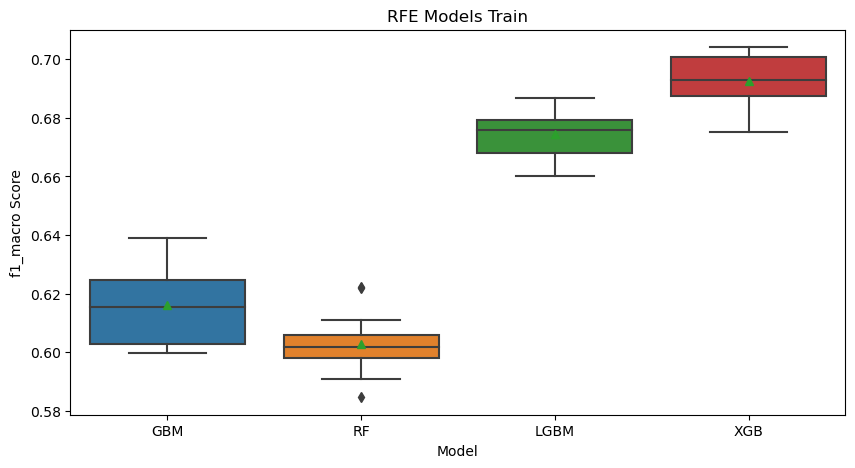

In [15]:
box_plot_models(results_train, names, primary_metric, 'RFE Models Train')

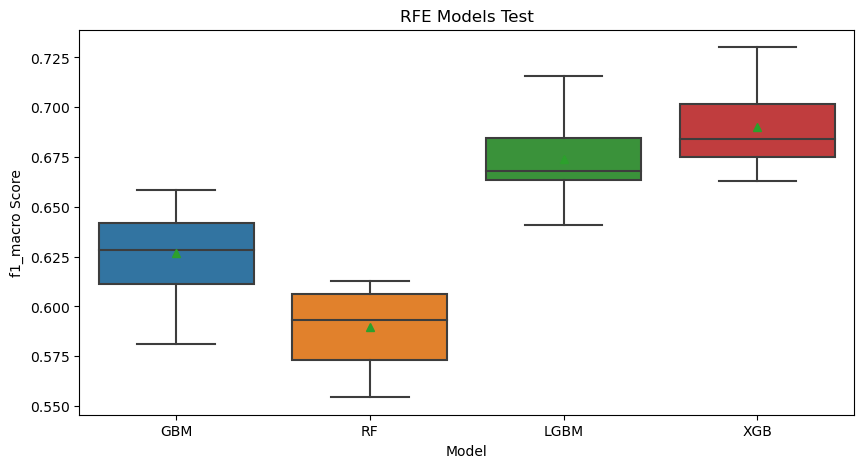

In [16]:
box_plot_models(results_test, names, primary_metric, 'RFE Models Test')

In [17]:
model_base = dict()
model_base['train'] = results_train
model_base['test'] = results_test

model_base_train = pd.DataFrame(model_base['train']).T
model_base_train.columns = names

model_base_test = pd.DataFrame(model_base['test']).T
model_base_test.columns = names

In [18]:
model_base_train.to_csv('data/model_base_train.csv')
model_base_test.to_csv('data/model_base_test.csv')

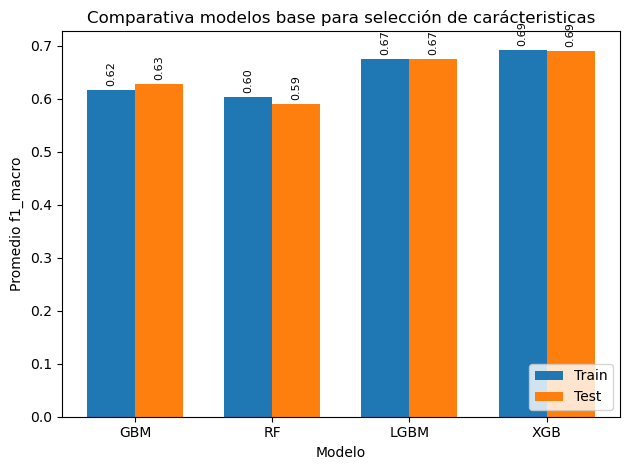

In [19]:
graph_train_test_models(train=model_base_train, 
                        test=model_base_test, 
                        metric_name=primary_metric, 
                        title_fig='Comparativa modelos base para selección de carácteristicas')

In [20]:
RFE_XBG = RFECV(estimator=XGBClassifier(), step=3, cv=5)
RFE_XBG.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      step=3)

In [21]:
rank_XBG = feature_rank(X_train, RFE_XBG).sort_values('selected', ascending=False)
rank_XBG

,name_feature,selected,rank
0,cons_descproducto_mas_freq,True,1
1,cons_descproducto_mas_freq_total,True,1
18,usu_canal_registro,True,1
17,usu_tipousuario,True,1
16,ses_total_sesiones,True,1
15,ses_fechas_total_sesion,True,1
14,ses_dias_min_entre_sesion,True,1
13,ses_dias_max_entre_sesion,True,1
12,pcons_numusuarios,True,1
11,pcons_numconsumos,True,1


<div class="alert alert-block alert-info">
    <strong>Observaciones:</strong> 
    
A partir del método RFE se seleccionarion 17 de las 20 variables.  <strong>Descartándose pcons_empconsul_sector, cons_empconsul_prov_desc_mas_freq, cons_empconsul_sector_mas_freq</strong>.
</div>

In [22]:
feature_selected = rank_XBG[rank_XBG['selected'] == True]['name_feature'].to_list()

In [8]:
feature_selected = ["cons_descproducto_mas_freq", "cons_descproducto_mas_freq_total", "usu_canal_registro", "usu_tipousuario", "ses_total_sesiones", "ses_fechas_total_sesion", "ses_dias_min_entre_sesion", "ses_dias_max_entre_sesion", "pcons_numusuarios", "pcons_numconsumos", "pcons_empconsul_prov_desc", "pcons_descproducto", "cons_total_usuarios", "cons_total_consumos", "cons_empconsul_prov_desc_mas_freq_total", "cons_empconsul_sector_mas_freq_total", "usu_bondad_email"]

In [9]:
X_train = X_train.loc[:, feature_selected]
X_test = X_test.loc[:, feature_selected]

# 3. Generación de modelos predictivos basado en métodos de muestreo

En esta sección se desarrolla el primer método para la generación de modelos predictivos basada en técnicas de muestreo. Antes de aplicar las técnicas, es necesario definir los modelos base, que tengan en el mejor desempeño con sus parámetros por defecto. 

## 3.1. Selección modelo base

In [18]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def get_models():
    """
    Devuelve una lista de modelos de clasificación y sus nombres asociados.

    Salida:
    - Una tupla que contiene dos listas:
      1. Una lista de modelos de clasificación (instancias de los clasificadores).
      2. Una lista de nombres asociados a cada modelo.
    """
    models, names = list(), list()
    # SVM
    models.append(SVC())
    names.append('SVM')    
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # GBM
    models.append(GradientBoostingClassifier())
    names.append('GBM')    
     # ADB
    models.append(AdaBoostClassifier())
    names.append('ADB')      
     # ET
    models.append(ExtraTreesClassifier())
    names.append('ET')       
    # RF
    models.append(RandomForestClassifier())
    names.append('RF')
    # Bagging
    models.append(BaggingClassifier())
    names.append('Bagging')                  
    # LGBM
    models.append(LGBMClassifier())
    names.append('LGBM')
    # XGB
    models.append(XGBClassifier())
    names.append('XGB')

    return models, names

In [19]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def evaluate_model(X, y, model):    
    """
    Evalúa el rendimiento de un modelo de clasificación utilizando validación cruzada estratificada repetida.

    Parámetros:
    - X (array-like): Matriz de características de entrada.
    - y (array-like): Vector de etiquetas de clase correspondiente a las características.
    - model: Modelo de clasificación a evaluar.

    Salida:
    - Una lista de puntajes de rendimiento del modelo en diferentes particiones de validación cruzada.    
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X, y, scoring=primary_metric, cv=cv, n_jobs=n_jobs)
    return scores

In [20]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

models, names = get_models()
results_train = list()
results_test = list()

for i in range(len(models)):
    if names[i] in ['SVM', 'KNN']:        
        scores_train = evaluate_model(np.sqrt(MinMaxScaler().fit_transform(X_train)), y_train, models[i])
        scores_test = evaluate_model(np.sqrt(MinMaxScaler().fit_transform(X_test)), y_test, models[i])           
    else:
        scores_train = evaluate_model(X_train, y_train, models[i])
        scores_test = evaluate_model(X_test, y_test, models[i])
    results_train.append(scores_train)
    results_test.append(scores_test)

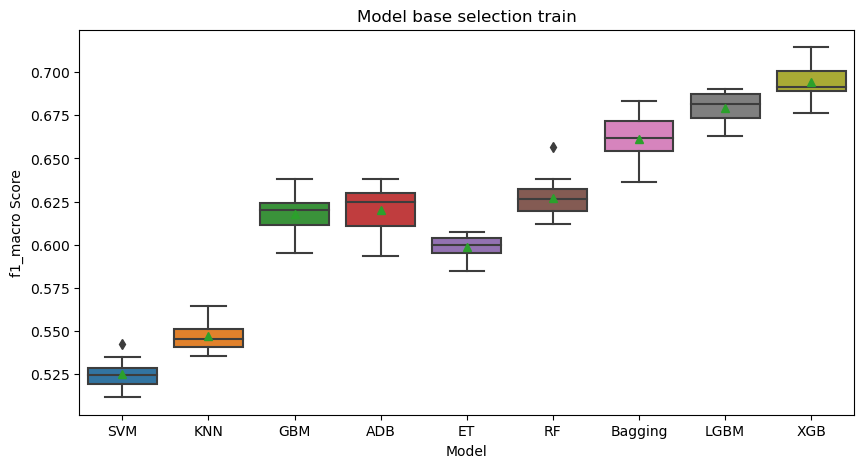

In [23]:
box_plot_models(results_train, names, primary_metric, 'Model base selection train')

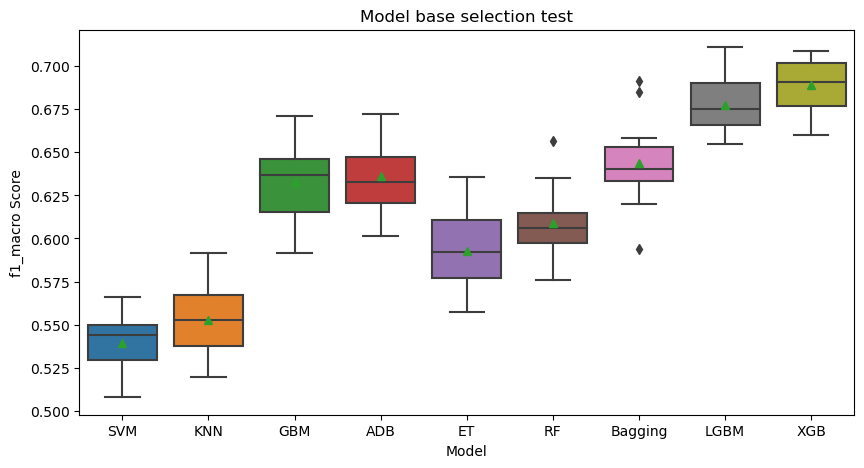

In [24]:
box_plot_models(results_test, names, primary_metric, 'Model base selection test')

In [25]:
model_base_resampling = dict()
model_base_resampling['train'] = results_train
model_base_resampling['test'] = results_test

model_base_res_train = pd.DataFrame(model_base_resampling['train']).T
model_base_res_train.columns = names

model_base_res_test = pd.DataFrame(model_base_resampling['test']).T
model_base_res_test.columns = names

In [26]:
model_base_res_train.to_csv('data/model_base_res_train.csv')
model_base_res_test.to_csv('data/model_base_res_test.csv')

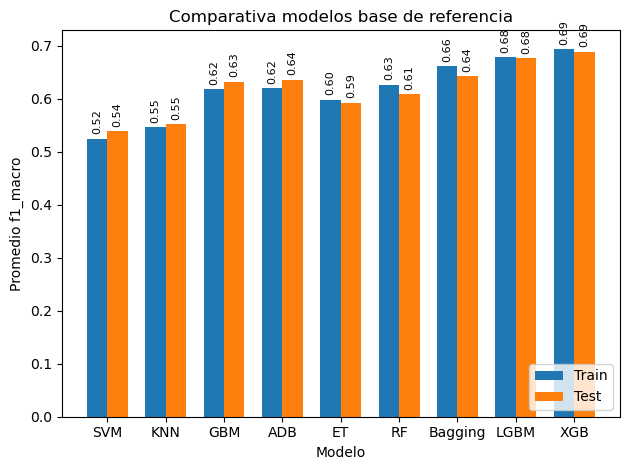

In [27]:
graph_train_test_models(train=model_base_res_train, 
                        test=model_base_res_test, 
                        metric_name=primary_metric, 
                        title_fig='Comparativa modelos base de referencia')

<div class="alert alert-block alert-info">
    <strong>Observaciones:</strong> 

De acuerdo con la figura anterior, los modelos que obtienen un mejor resultado en promedio sobre la métrica f1_macro son <strong>LGBM y XGB</strong> .

</div>

## 3.2 Selección modelo base resampling

Con los modelos base definidos se procede aplicar las técnicas de muestreo. De acuerdo con lo reportado en la literatura y la documentación de la librería imbalanced-learn, estas técnicas se dividen en tres categorías: sobremuestreo, submuestreo y combinadas.

In [62]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

def get_models():
    """
    Devuelve una lista de modelos de muestreo y sus nombres asociados.

    Salida:
    - Una tupla que contiene dos listas:
      1. Una lista de modelos de muestreo (instancias de los modelos).
      2. Una lista de nombres asociados a cada modelo.
    """    
    models, names = list(), list()
    
    # RandomUnderSampler
    models.append(RandomUnderSampler())
    names.append('RUS')
    # AllKNN    
    models.append(AllKNN())
    names.append('AllKNN') 
    # CondensedNearestNeighbour    
    models.append(CondensedNearestNeighbour())
    names.append('CNN')   
    
    # RandomOverSampler
    models.append(RandomOverSampler())
    names.append('ROS')
    # SMOTE
    models.append(SMOTE())
    names.append('SMOTE')
    # BorderlineSMOTE
    models.append(BorderlineSMOTE())
    names.append('BLSMOTE')
    # SVMSMOTE
    models.append(SVMSMOTE())
    names.append('SVMSMOTE')
    # ADASYN
    models.append(ADASYN())
    names.append('ADASYN')
    
    # SMOTETomek
    models.append(SMOTETomek())
    names.append('SMOTETomek')
    # SMOTEENN
    models.append(SMOTEENN())
    names.append('SMOTEENN')    
    
    return models, names

Para obtener los mejores modelos de referencia aplicando las técnicas de muestreo, se procede a entrenar y evaluar los dos mejores modelos y las 10 técnicas de muestreo. Es de destacar que el entrenamiento se hace con la técnica de validación cruzada estratificada y parámetros por defecto.

In [47]:
# Adapatado de https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

models, names = get_models()
results_train = list()
results_test = list()

for i in range(len(models)):
    
    model = LGBMClassifier()

    steps = [('o', models[i]), ('m', model)]

    pipeline = Pipeline(steps=steps)
    
    scores_train = evaluate_model(X_train, y_train, pipeline)
    scores_test = evaluate_model(X_test, y_test, pipeline)
    results_train.append(scores_train)
    results_test.append(scores_test)

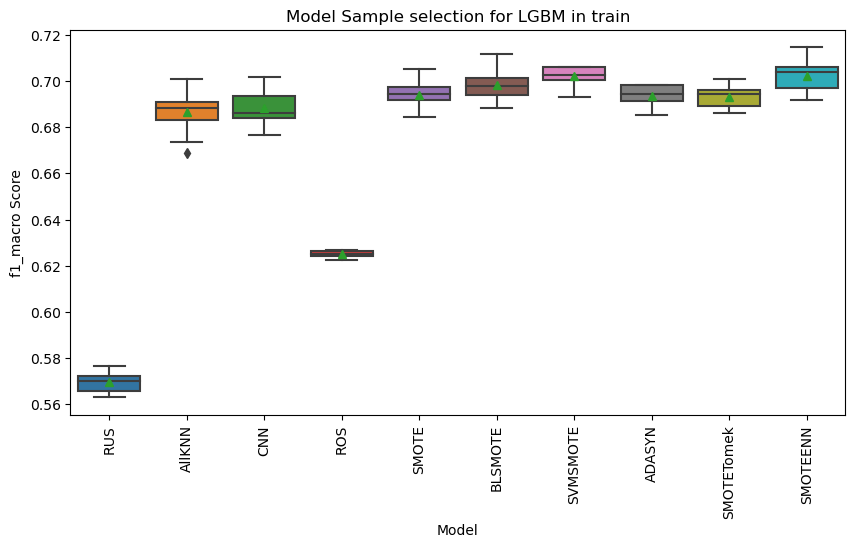

In [64]:
box_plot_models(results_train, names, primary_metric, 90, 'Model Sample selection for LGBM in train')

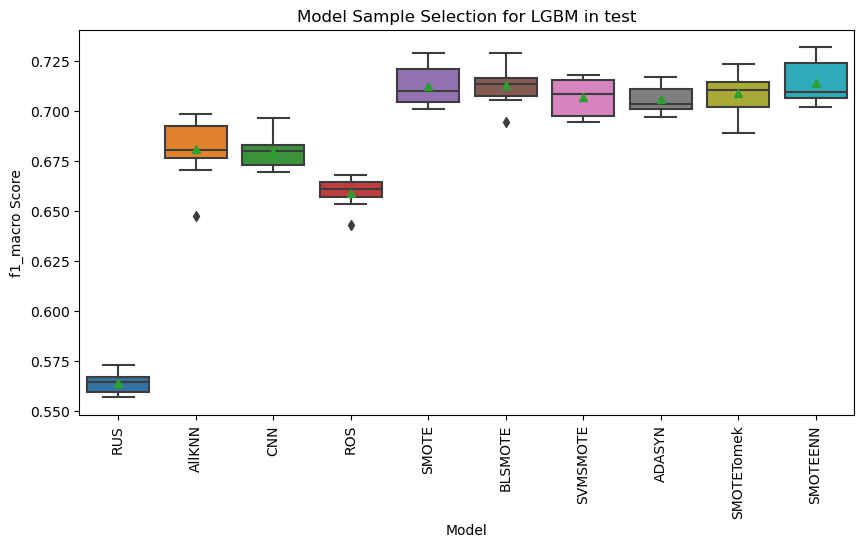

In [65]:
box_plot_models(results_test, names, primary_metric, 90, 'Model Sample Selection for LGBM in test')

In [66]:
model_resample_LGBM = dict()
model_resample_LGBM['train'] = results_train
model_resample_LGBM['test'] = results_test

In [67]:
model_resample_LGBM_train = pd.DataFrame(model_resample_LGBM['train']).T
model_resample_LGBM_train.columns = names
model_resample_LGBM_test = pd.DataFrame(model_resample_LGBM['test']).T
model_resample_LGBM_test.columns = names

In [68]:
model_resample_LGBM_train.to_csv('data/model_resample_LGBM_train.csv')
model_resample_LGBM_test.to_csv('data/model_resample_LGBM_test.csv')

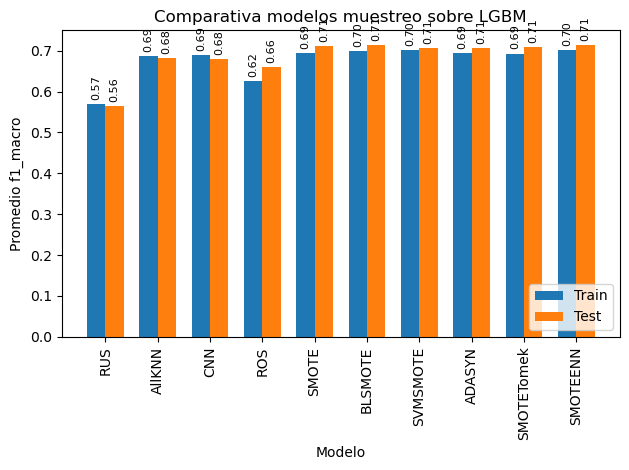

In [70]:
graph_train_test_models(train=model_resample_LGBM_train, 
                        test=model_resample_LGBM_test, 
                        metric_name=primary_metric, 
                        angle_rotate=90,
                        title_fig='Comparativa modelos muestreo sobre LGBM')

<div class="alert alert-block alert-info">
    <strong>Observaciones:</strong> 
    
De acuerdo con la figura anterior los modelos de remuestreo con LGBM que obtienen el mejor resultado en promedio sobre la métrica f1_macro son <strong>SVMSMOTE, BLSMOTE,  SMOTEENN</strong>.    
    
</div>

In [71]:
models, names = get_models()
results_train = list()
results_test = list()

for i in range(len(models)):
    
    model = XGBClassifier()

    steps = [('o', models[i]), ('m', model)]

    pipeline = Pipeline(steps=steps)
    
    scores_train = evaluate_model(X_train, y_train, pipeline)
    scores_test = evaluate_model(X_test, y_test, pipeline)
    results_train.append(scores_train)
    results_test.append(scores_test)

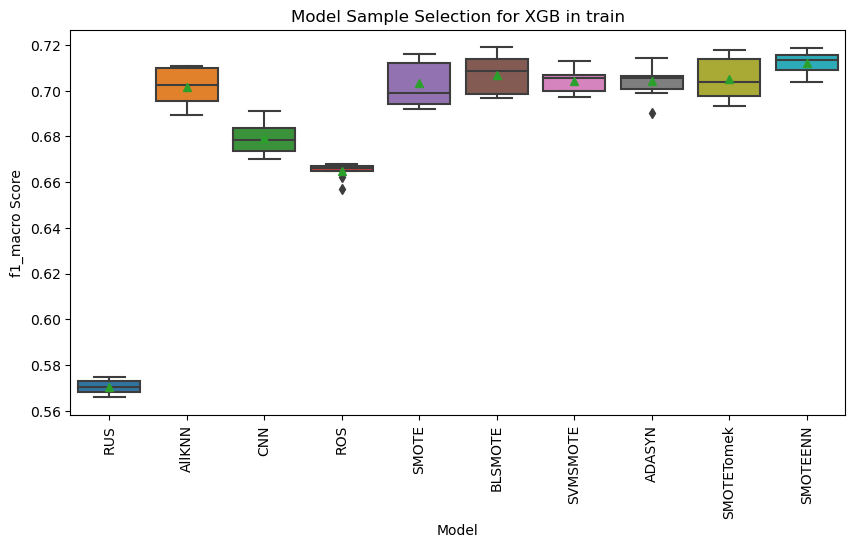

In [72]:
box_plot_models(results_train, names, primary_metric, 90, 'Model Sample Selection for XGB in train')

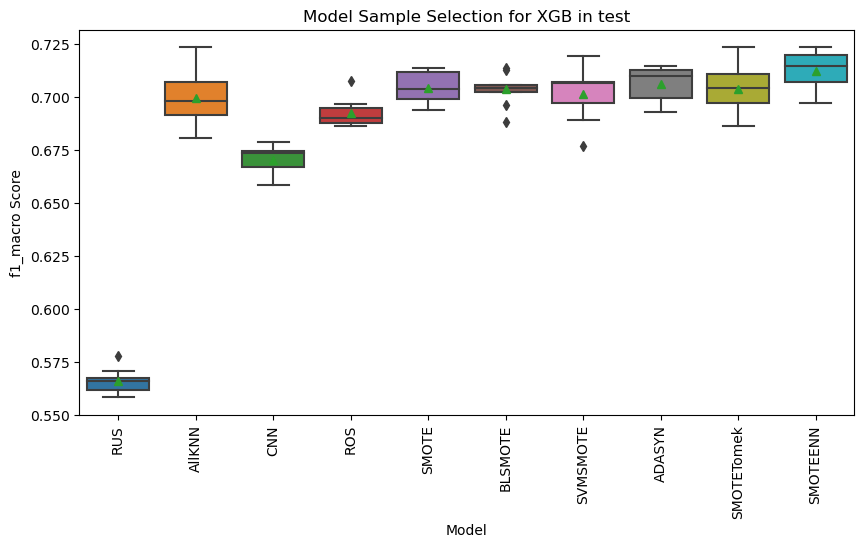

In [73]:
box_plot_models(results_test, names, primary_metric, 90, 'Model Sample Selection for XGB in test')

In [74]:
model_resampling_XGB = dict()
model_resampling_XGB['train'] = results_train
model_resampling_XGB['test'] = results_test

In [75]:
model_resampling_XGB_train = pd.DataFrame(model_resampling_XGB['train']).T
model_resampling_XGB_train.columns = names
model_resampling_XGB_test = pd.DataFrame(model_resampling_XGB['test']).T
model_resampling_XGB_test.columns = names

In [76]:
model_resampling_XGB_train.to_csv('data/model_resampling_XGB_train.csv')
model_resampling_XGB_test.to_csv('data/model_resampling_XGB_test.csv')

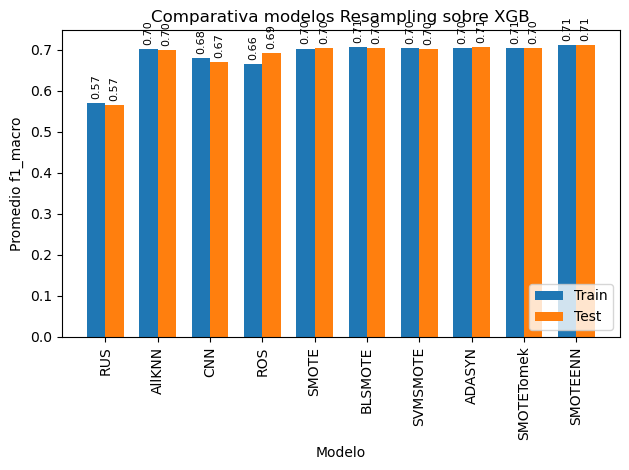

In [78]:
graph_train_test_models(train=model_resampling_XGB_train, 
                        test=model_resampling_XGB_test, 
                        metric_name=primary_metric, 
                        angle_rotate=90,
                        title_fig='Comparativa modelos Resampling sobre XGB')

<div class="alert alert-block alert-info">
    <strong>Observaciones:</strong> 
    
De acuerdo con la figura anterior los modelos de remuestreo con XGB que obtienen el mejor resultado en promedio sobre la métrica f1_macro son <strong>ADASYN, BLSMOTE, SVMSMOTE, SMOTEEN, SMOTEENN y SMOTETomek.</strong>    
    
</div>

## 3.3 Optimización de hyperparámetros

Definidos los mejores modelos, el paso siguiente es optimizar los hiperparámetros y evaluar los modelos. Para esto se usará la técnica de optimización bayesiana y validación cruzada estratificada. 

### 3.3.1. Model LightGBM y muestreo SVMSMOTE

In [101]:
X_train_res, y_train_res = SVMSMOTE().fit_resample(X_train, y_train)

In [ ]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([98085, 98085], dtype=int64))


In [122]:
search_space = {
    'learning_rate': Real(0.01, 0.5),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 20)
}

lgbm = LGBMClassifier()
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
lgbm_svmsmote = BayesSearchCV(lgbm, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
lgbm_svmsmote.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=LGBMClassifier(), n_iter=32, n_jobs=6, random_state=123,
              scoring='f1_macro',
              search_spaces={'learning_rate': Real(low=0.01, high=0.5, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=20, high=150, prior='uniform', transform='normalize')})

In [123]:
best_lgbm_svmsmote = lgbm_svmsmote.best_estimator_
best_lgbm_svmsmote.booster_.save_model('data/models/best_lgbm_svmsmote.bin')

In [5]:
feature_labels = list(X_train.columns)

LGBMClassifier(learning_rate=0.054950342219373255, max_depth=13,
               n_estimators=1000, num_leaves=144)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 196170 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 2.172 seconds
 Testing Time: 0.43 seconds
---------------------------------------------
Train Accuracy:  0.9995819952082378
 Test Accuracy:  0.98402652903949
---------------------------------------------
Train F1 Score:  0.9995819184843014
 Test F1 Score:  0.4420880913539967

Train Precision Score:  0.9997654234107436
 Test Precision Score:  0.6145124716553289

Train Recall Score:  0.9993984809094153
 Test Recall Score:  0.3452229299363057

---------------------------------------------
 Area Under ROC (test):  0.9526046373354231
---------------------------------------------
Model Memory Size: 15764.68 kB

===============================> CLASSIFICATION REPORT <=======

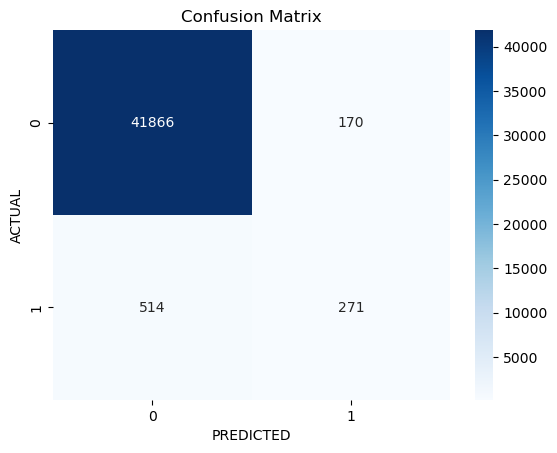


=======================================> PLOTS <=========================================



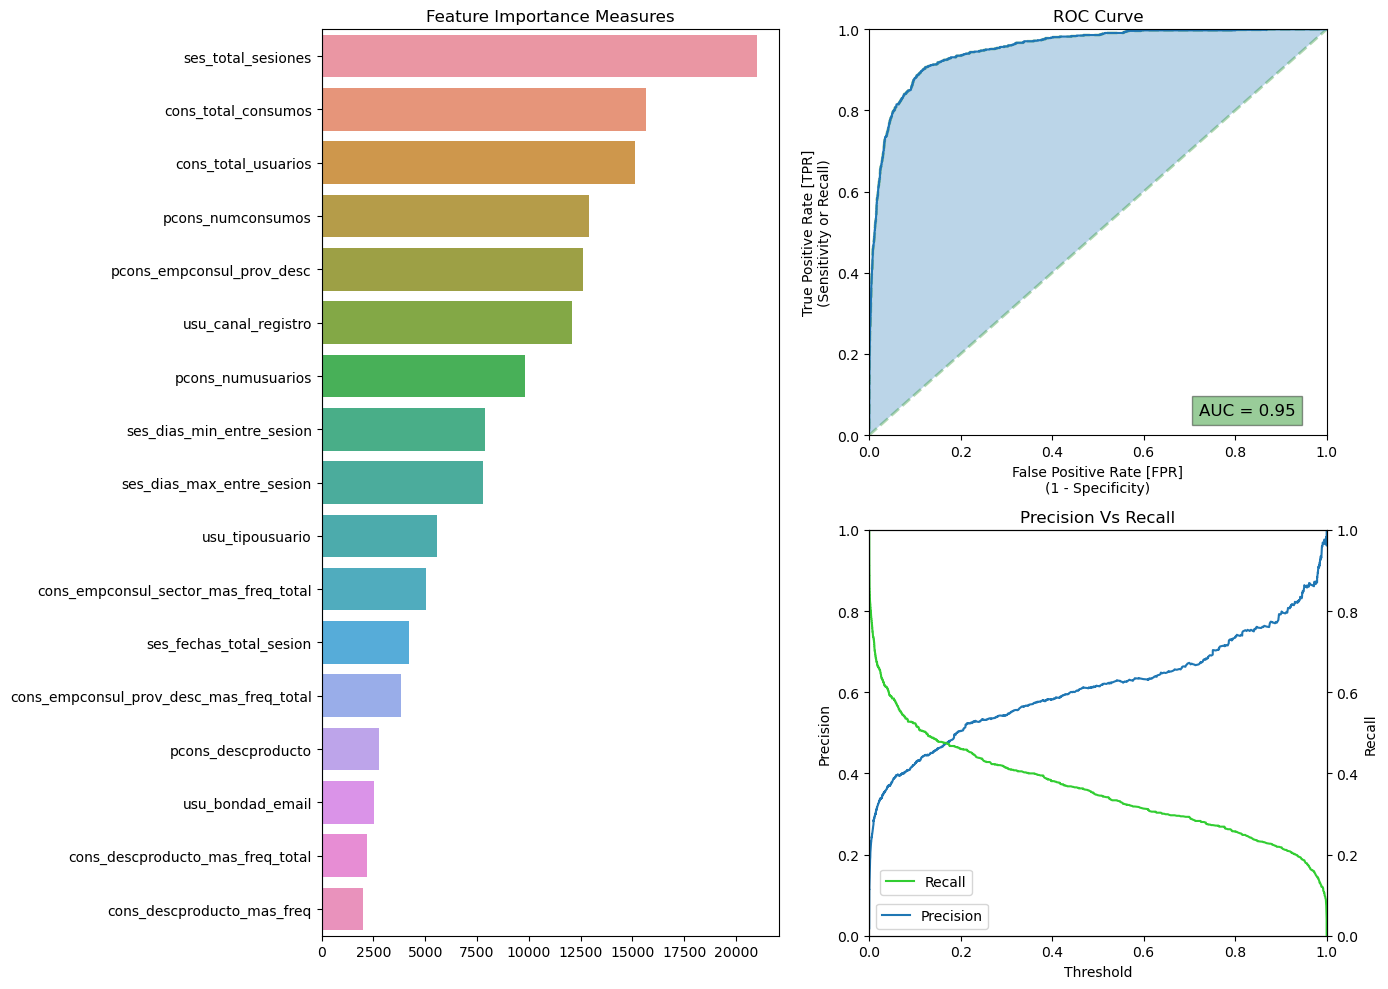

In [125]:
lgbm_svmsmote_model, lgbm_svmsmote_report = mpd.report(best_lgbm_svmsmote, 
                                                         'LGBM SVMSMOTE', 
                                                          X_train_res, 
                                                          y_train_res, 
                                                          X_test,
                                                          y_test,
                                                          display_scores=primary_eval_metric, 
                                                          importance_plot=True, 
                                                          confusion_labels=confusion_labels, 
                                                          feature_labels=feature_labels, 
                                                          verbose=True)

In [127]:
with open('data/reports/lgbm_svmsmote_report.pkl', 'wb') as fp:
    pickle.dump(lgbm_svmsmote_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 3.3.2. Model LigthGBM y muestreo BLSMOTE

In [142]:
X_train_res, y_train_res = BorderlineSMOTE().fit_resample(X_train, y_train)

In [143]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([98085, 98085], dtype=int64))


In [144]:
search_space = {
    'learning_rate': Real(0.01, 0.5),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 20)
}

lgbm = LGBMClassifier()
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
lgbm_blsmote = BayesSearchCV(lgbm, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
lgbm_blsmote.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=LGBMClassifier(), n_iter=32, n_jobs=6, random_state=123,
              scoring='f1_macro',
              search_spaces={'learning_rate': Real(low=0.01, high=0.5, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=20, high=150, prior='uniform', transform='normalize')})

In [145]:
best_lgbm_blsmote = lgbm_blsmote.best_estimator_
best_lgbm_blsmote.booster_.save_model('data/models/best_lgbm_blsmote.bin')

LGBMClassifier(learning_rate=0.1303203250023838, max_depth=10, n_estimators=506,
               num_leaves=73)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 196170 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.714 seconds
 Testing Time: 0.14 seconds
---------------------------------------------
Train Accuracy:  0.9993984809094153
 Test Accuracy:  0.9836528805959692
---------------------------------------------
Train F1 Score:  0.9993982907377568
 Test F1 Score:  0.44267515923566875

Train Precision Score:  0.9997143527539455
 Test Precision Score:  0.5902335456475584

Train Recall Score:  0.9990824285058878
 Test Recall Score:  0.354140127388535

---------------------------------------------
 Area Under ROC (test):  0.9535788099130076
---------------------------------------------
Model Memory Size: 4002.29 kB

===============================> CLASSIFICATION REPORT <==========

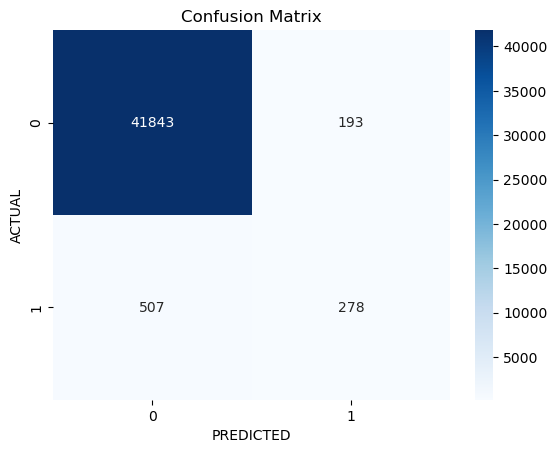


=======================================> PLOTS <=========================================



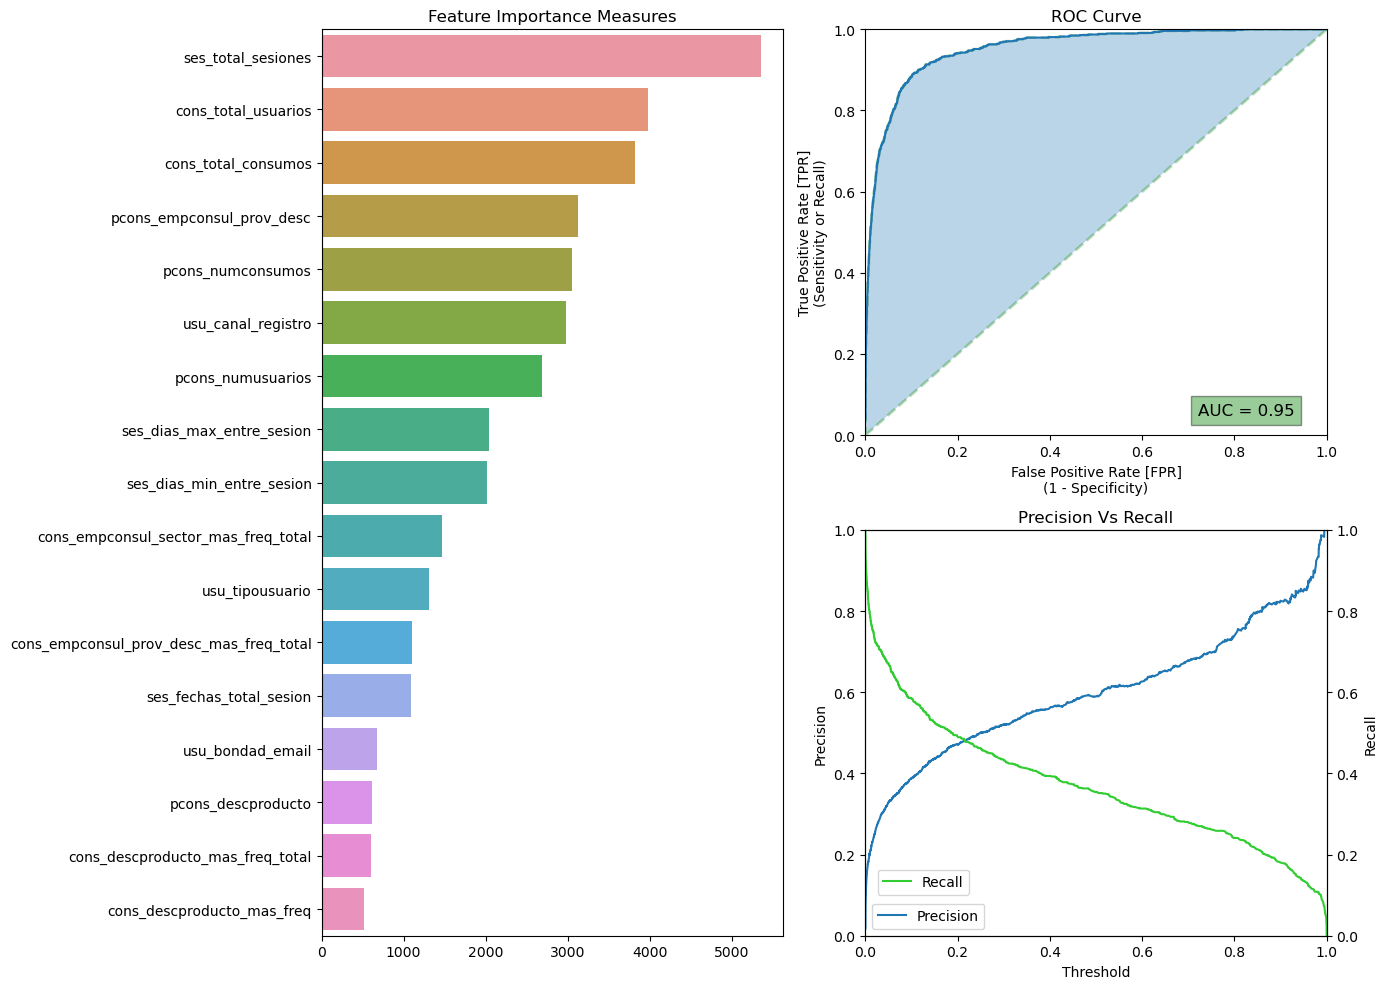

In [146]:
lgbm_blsmote_model, lgbm_blsmote_report = mpd.report(best_lgbm_blsmote, 
                                                         'LGBM BLSMOTE', 
                                                          X_train_res, 
                                                          y_train_res, 
                                                          X_test,
                                                          y_test,
                                                          display_scores=primary_eval_metric, 
                                                          importance_plot=True, 
                                                          confusion_labels=confusion_labels, 
                                                          feature_labels=feature_labels, 
                                                          verbose=True)

In [ ]:
with open('data/reports/lgbm_svmsmote_report.pkl', 'wb') as fp:
    pickle.dump(lgbm_svmsmote_report, fp)
    print('dictionary saved successfully to file')

### 3.3.3. Model LigthGBM y muestreo SMOTEENN

In [82]:
X_train_res, y_train_res = SMOTEENN().fit_resample(X_train, y_train)

In [74]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([98085, 98085], dtype=int64))


In [83]:
search_space = {
    'learning_rate': Real(0.01, 0.5),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 20)
}

lgbm = LGBMClassifier()
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
lgbm_smoteenn = BayesSearchCV(lgbm, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
lgbm_smoteenn.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=LGBMClassifier(), n_iter=32, n_jobs=6, random_state=123,
              scoring='f1_macro',
              search_spaces={'learning_rate': Real(low=0.01, high=0.5, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=20, high=150, prior='uniform', transform='normalize')})

In [84]:
best_lgbm_smoteenn = lgbm_smoteenn.best_estimator_
best_lgbm_smoteenn.booster_.save_model('data/models/best_lgbm_smoteenn.bin')

LGBMClassifier(learning_rate=0.09557908624497849, max_depth=18,
               n_estimators=442, num_leaves=125)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 181878 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.732 seconds
 Testing Time: 0.135 seconds
---------------------------------------------
Train Accuracy:  0.9999945018089049
 Test Accuracy:  0.9820882277387263
---------------------------------------------
Train F1 Score:  0.9999946528925178
 Test F1 Score:  0.44540853217642806

Train Precision Score:  1.0
 Test Precision Score:  0.5150501672240803

Train Recall Score:  0.9999893058422183
 Test Recall Score:  0.3923566878980892

---------------------------------------------
 Area Under ROC (test):  0.9596708280982089
---------------------------------------------
Model Memory Size: 6015.53 kB

===============================> CLASSIFICATION REPORT <=====================

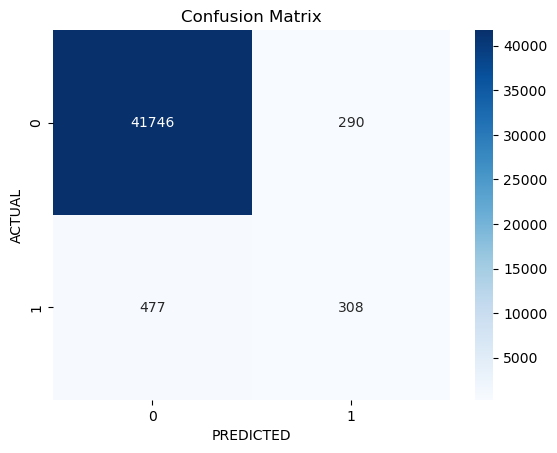


=======================================> PLOTS <=========================================



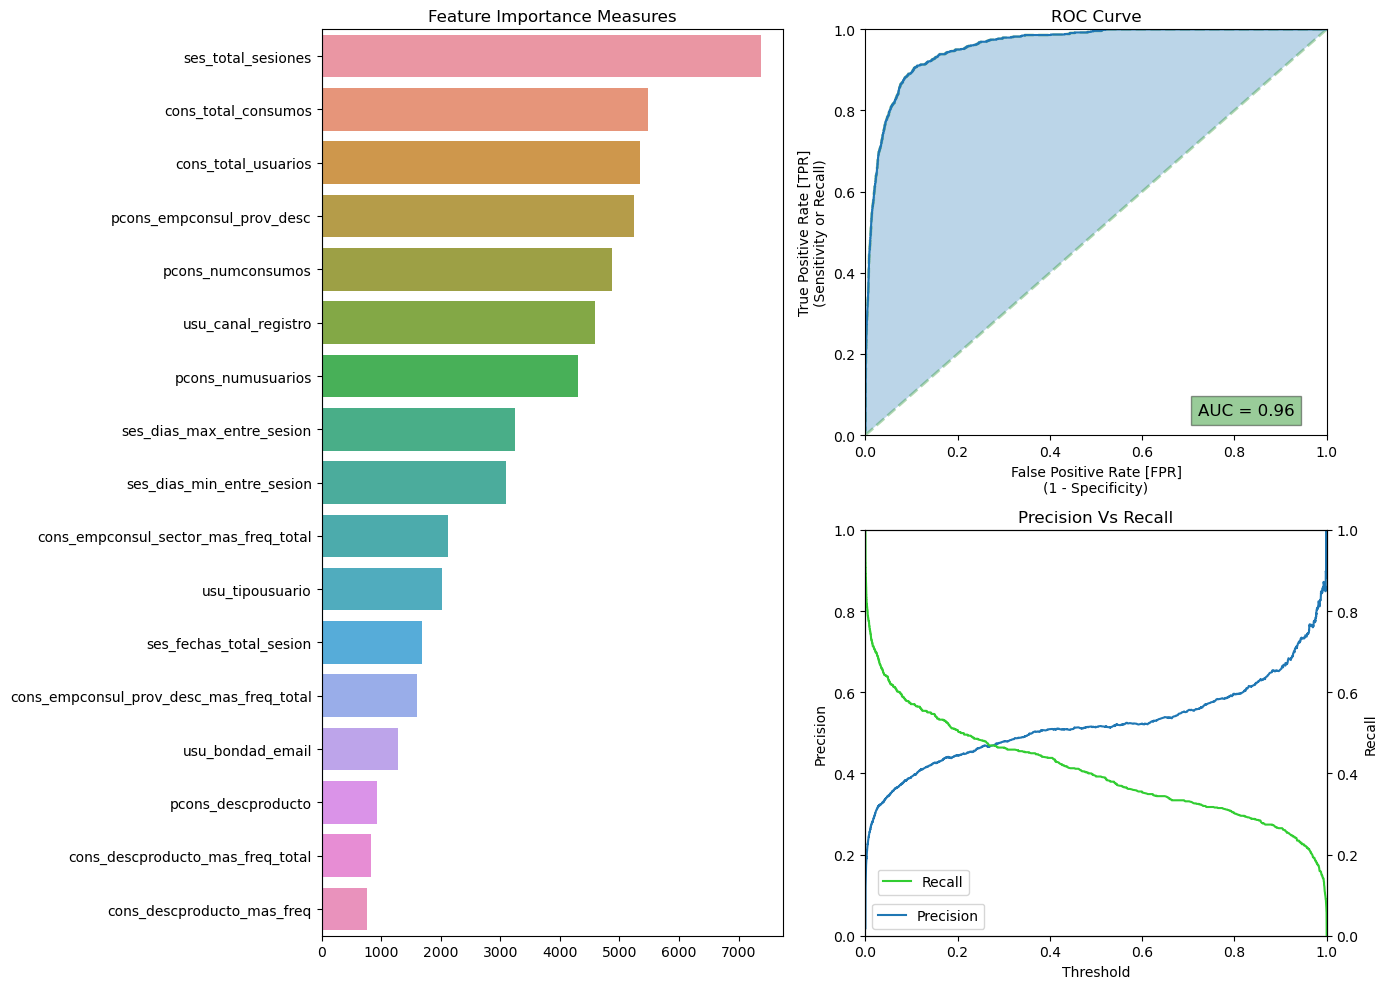

In [90]:
lgbm_smoteenn_model, lgbm_smoteenn_report = mpd.report(best_lgbm_smoteenn, 
                                                 'LGBM SMOTEENN', 
                                                  X_train_res, 
                                                  y_train_res, 
                                                  X_test,
                                                  y_test,
                                                  display_scores=primary_eval_metric, 
                                                  importance_plot=True, 
                                                  confusion_labels=confusion_labels, 
                                                  feature_labels=feature_labels, 
                                                  verbose=True)

In [147]:
with open('data/reports/lgbm_blsmote_report.pkl', 'wb') as fp:
    pickle.dump(lgbm_blsmote_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 3.3.4. Model XGBoost y muestreo ADASYN

In [149]:
X_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)

In [150]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([98085, 97802], dtype=int64))


In [151]:
search_space = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.3, 1)
}
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
xgb = XGBClassifier(random_state=seed)
xgb_adasyn = BayesSearchCV(xgb, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
xgb_adasyn.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      impor...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [152]:
best_xgb_adasyn = xgb_adasyn.best_estimator_
best_xgb_adasyn.save_model('data/models/xgb_adasyn.bin')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15888746676844745,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=349, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 195887 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.308 seconds
 Testing Time: 0.

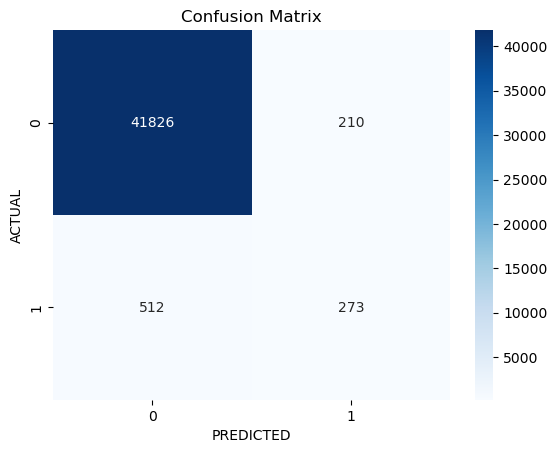


=======================================> PLOTS <=========================================



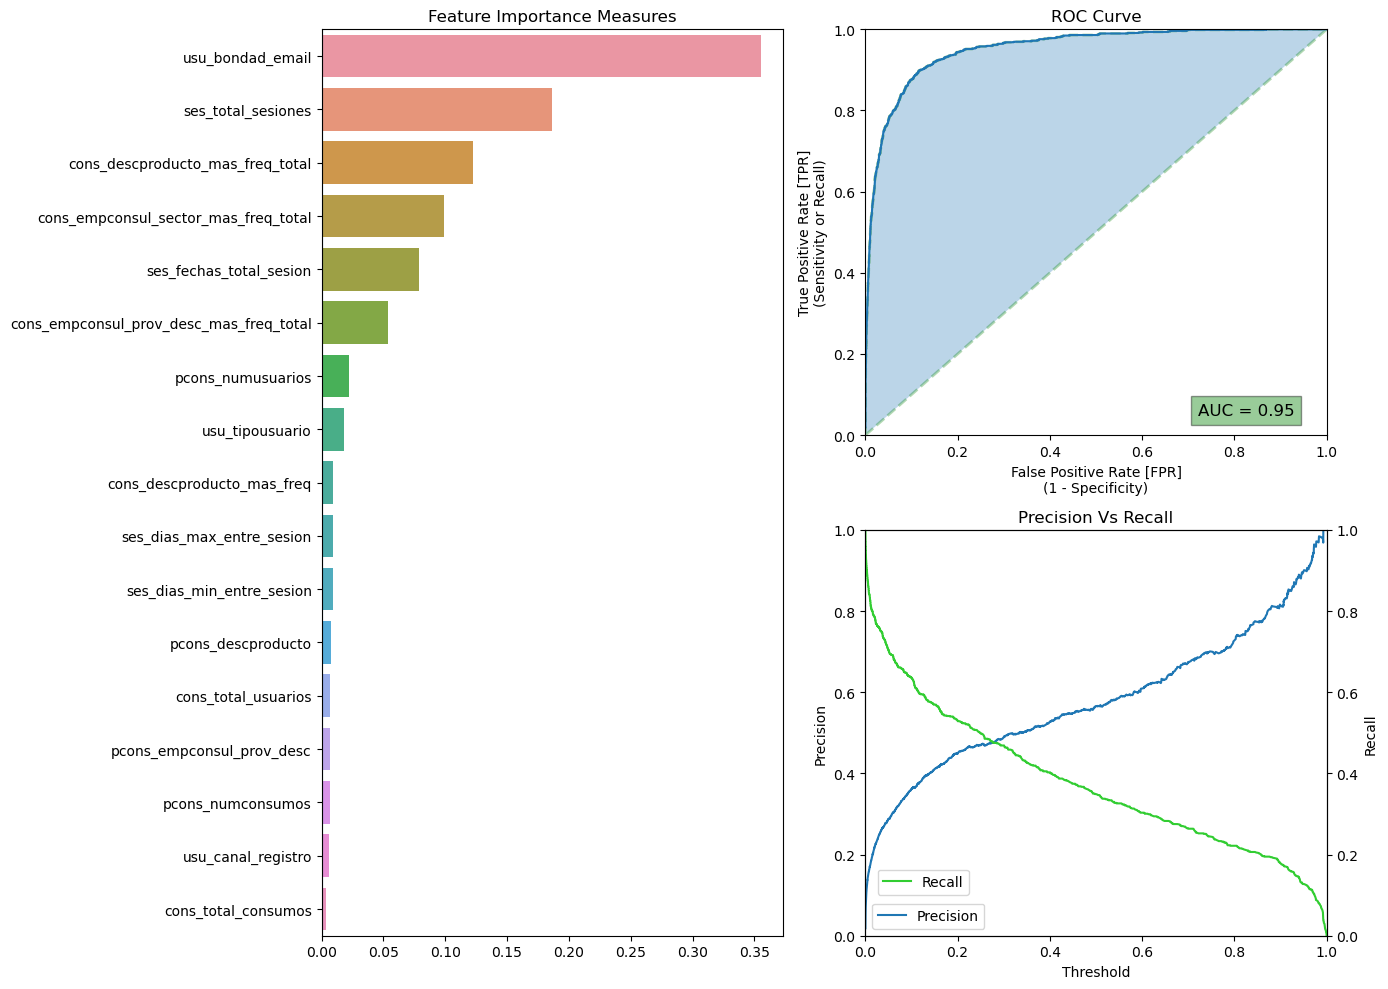

In [153]:
xgb_adasyn_model, xgb_adasyn_report = mpd.report(best_xgb_adasyn, 
                                             'XGBoost ADASYN',
                                              X_train_res, 
                                              y_train_res, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [154]:
with open('data/reports/xgb_adasyn_report.pkl', 'wb') as fp:
    pickle.dump(xgb_adasyn_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 3.3.5. Model XGBoost y muestreo SVMSMOTE

In [85]:
X_train_res, y_train_res = SVMSMOTE().fit_resample(X_train, y_train)

In [128]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([98085, 98085], dtype=int64))


In [129]:
search_space = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.3, 1)
}
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
xgb = XGBClassifier(random_state=seed)
xgb_svmsmote = BayesSearchCV(xgb, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
xgb_svmsmote.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      impor...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [130]:
best_xgb_svmsmote = xgb_svmsmote.best_estimator_
best_xgb_svmsmote.save_model('data/models/best_xgb_svmsmote.bin')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.0810941283144753, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.17642488974411044, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 196170 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0

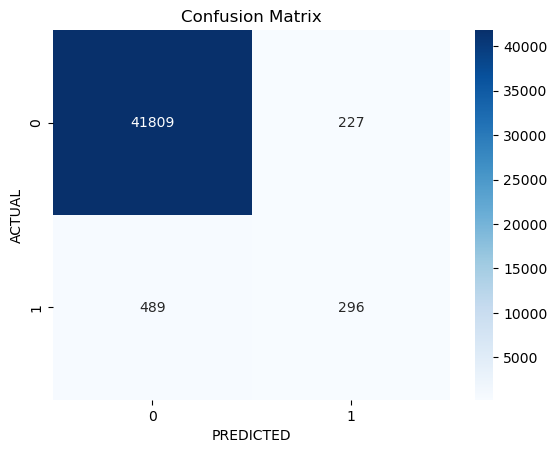


=======================================> PLOTS <=========================================



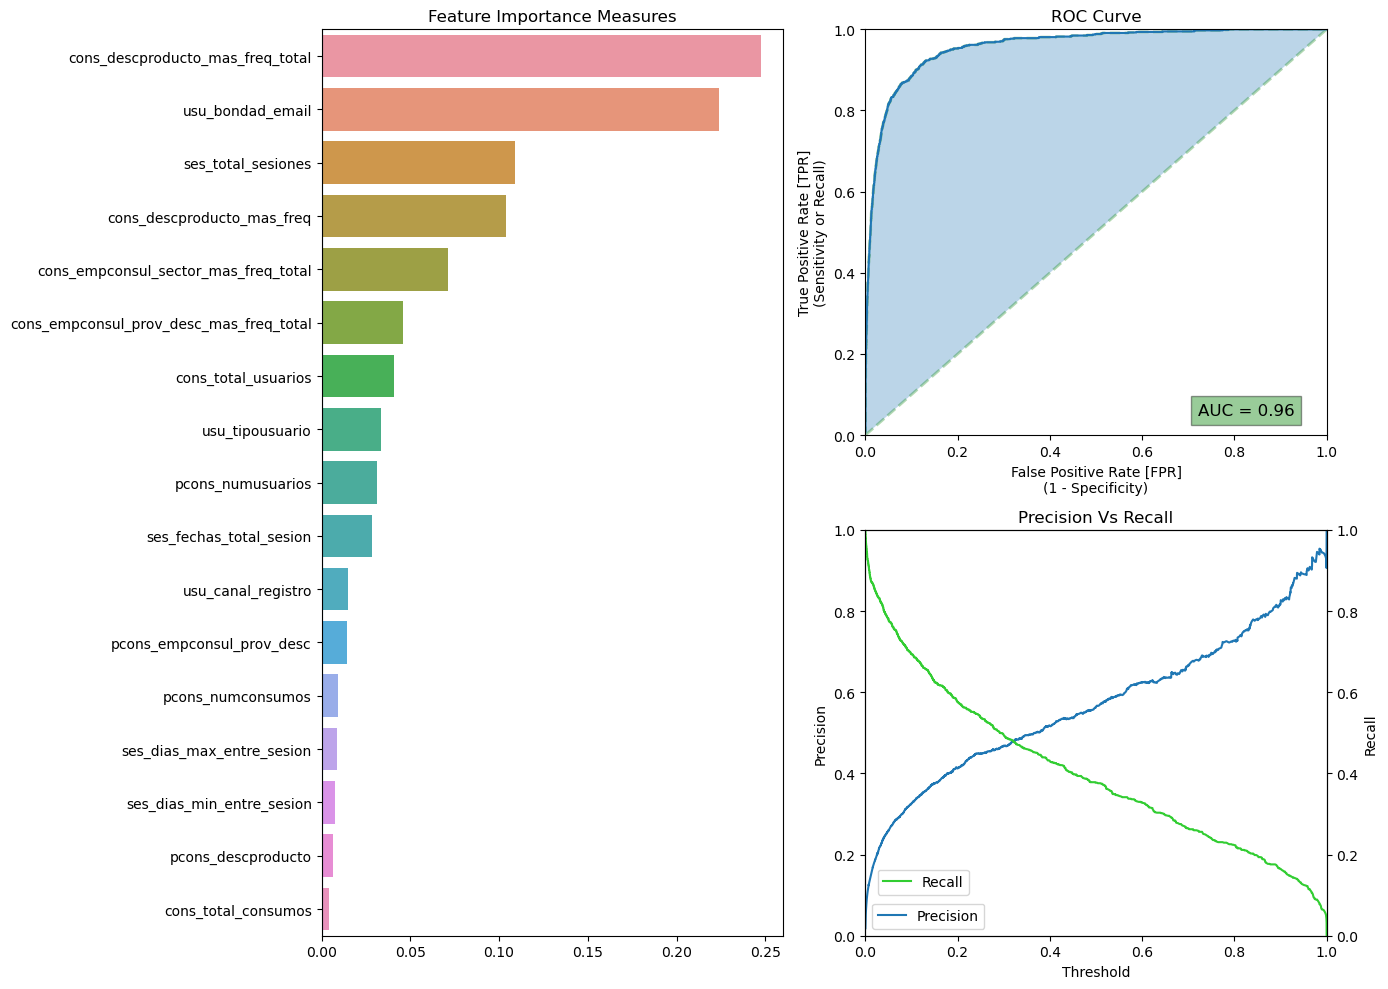

In [131]:
xgb_svmsmote_model, xgb_svmsmote_report = mpd.report(best_xgb_svmsmote, 
                                             'XGBoost SVMSMOTE',
                                              X_train_res, 
                                              y_train_res, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [200]:
with open('data/reports/xgb_svmsmote_report.pkl', 'wb') as fp:
    pickle.dump(xgb_svmsmote_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 3.3.6. Model XGBoost y muestreo BLSMOTE

In [155]:
X_train_res, y_train_res = BorderlineSMOTE().fit_resample(X_train, y_train)

In [156]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([98085, 98085], dtype=int64))


In [134]:
search_space = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.3, 1)
}
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
xgb = XGBClassifier(random_state=seed)
xgb_blsmote = BayesSearchCV(xgb, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
xgb_blsmote.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      impor...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [135]:
best_xgb_blsmote = xgb_blsmote.best_estimator_
best_xgb_blsmote.save_model('data/models/best_xgb_blsmote.bin')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05958510464367063,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 196170 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.712 seconds
 Testing Time: 0

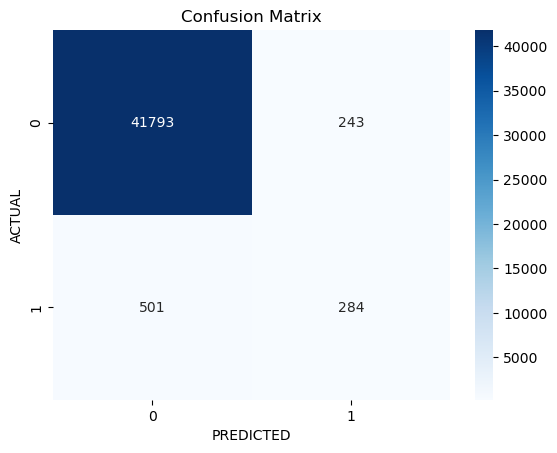


=======================================> PLOTS <=========================================



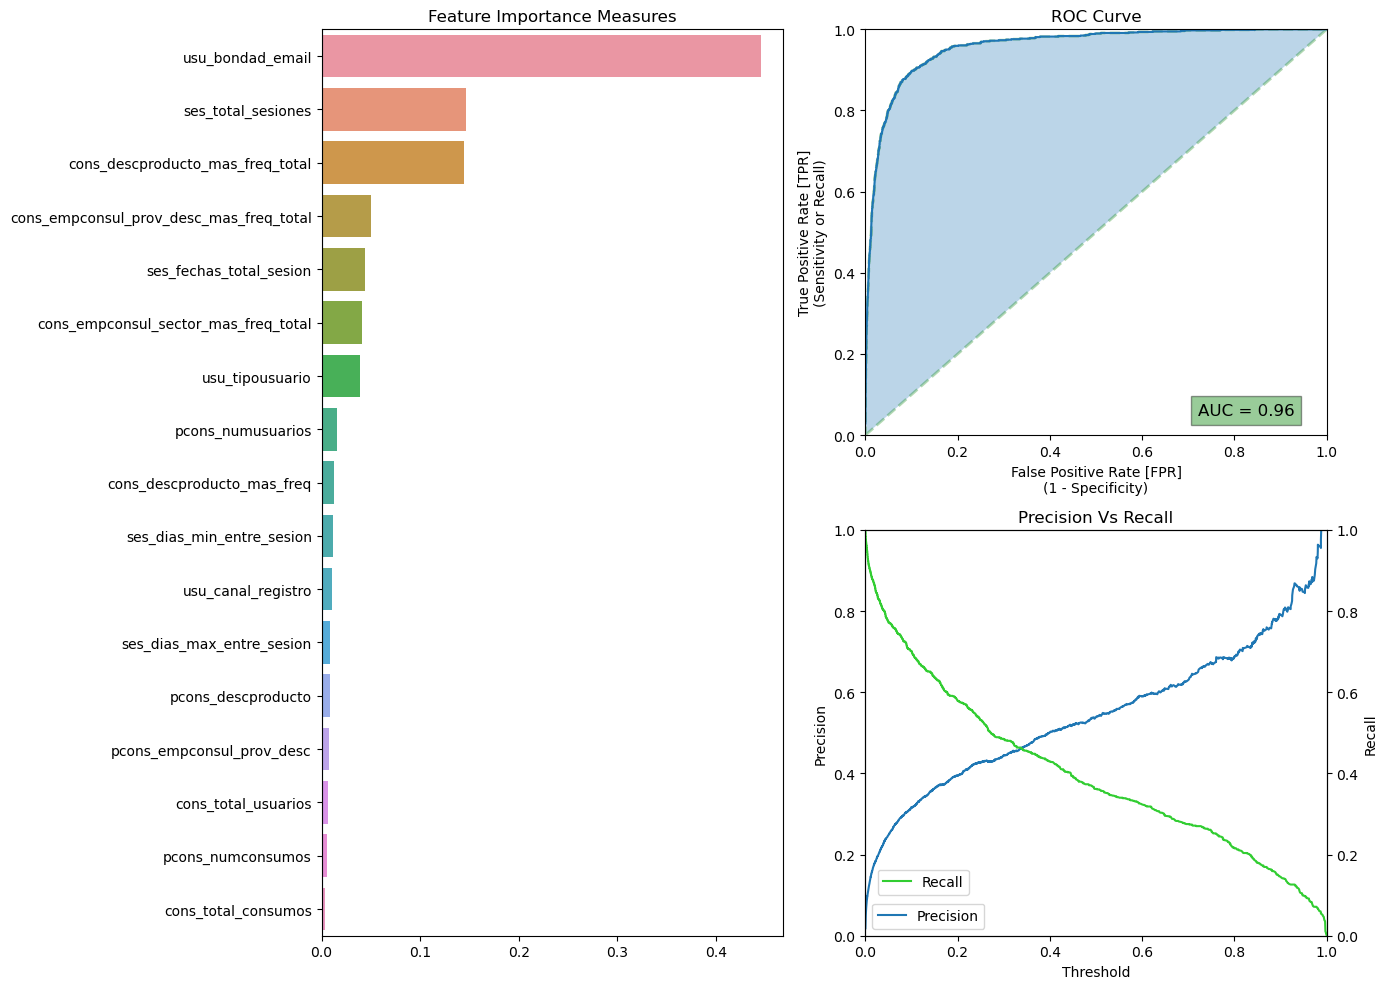

In [136]:
xgb_blsmote_model, xgb_blsmote_report = mpd.report(best_xgb_blsmote, 
                                             'XGBoost BLSMOTE',
                                              X_train_res, 
                                              y_train_res, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [140]:
with open('data/reports/xgb_blsmote_report.pkl', 'wb') as fp:
    pickle.dump(xgb_blsmote_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 3.3.7. Model XGBoost y muestreo SMOTEENN

In [ ]:
X_train_res, y_train_res = SMOTEENN().fit_resample(X_train, y_train)

In [91]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([88369, 93509], dtype=int64))


In [92]:
search_space = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.3, 1)
}
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
xgb = XGBClassifier(random_state=seed)
xgb_smoteenn = BayesSearchCV(xgb, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
xgb_smoteenn.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      impor...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [93]:
best_xgb_smoteenn = xgb_smoteenn.best_estimator_
best_xgb_smoteenn.save_model('data/models/best_xgb_smoteenn.bin')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2733116589723643,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=647, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 181878 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.448 seconds
 Testing Time: 0.09

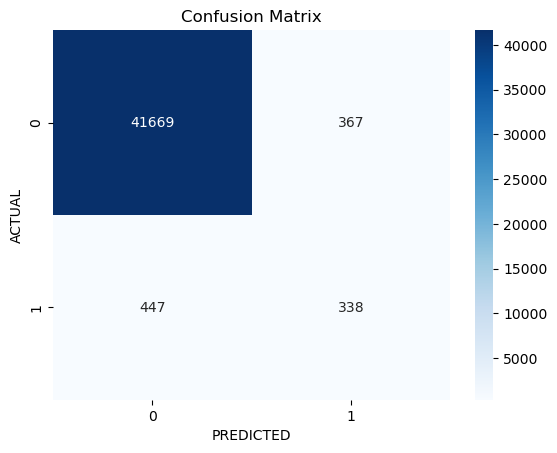


=======================================> PLOTS <=========================================



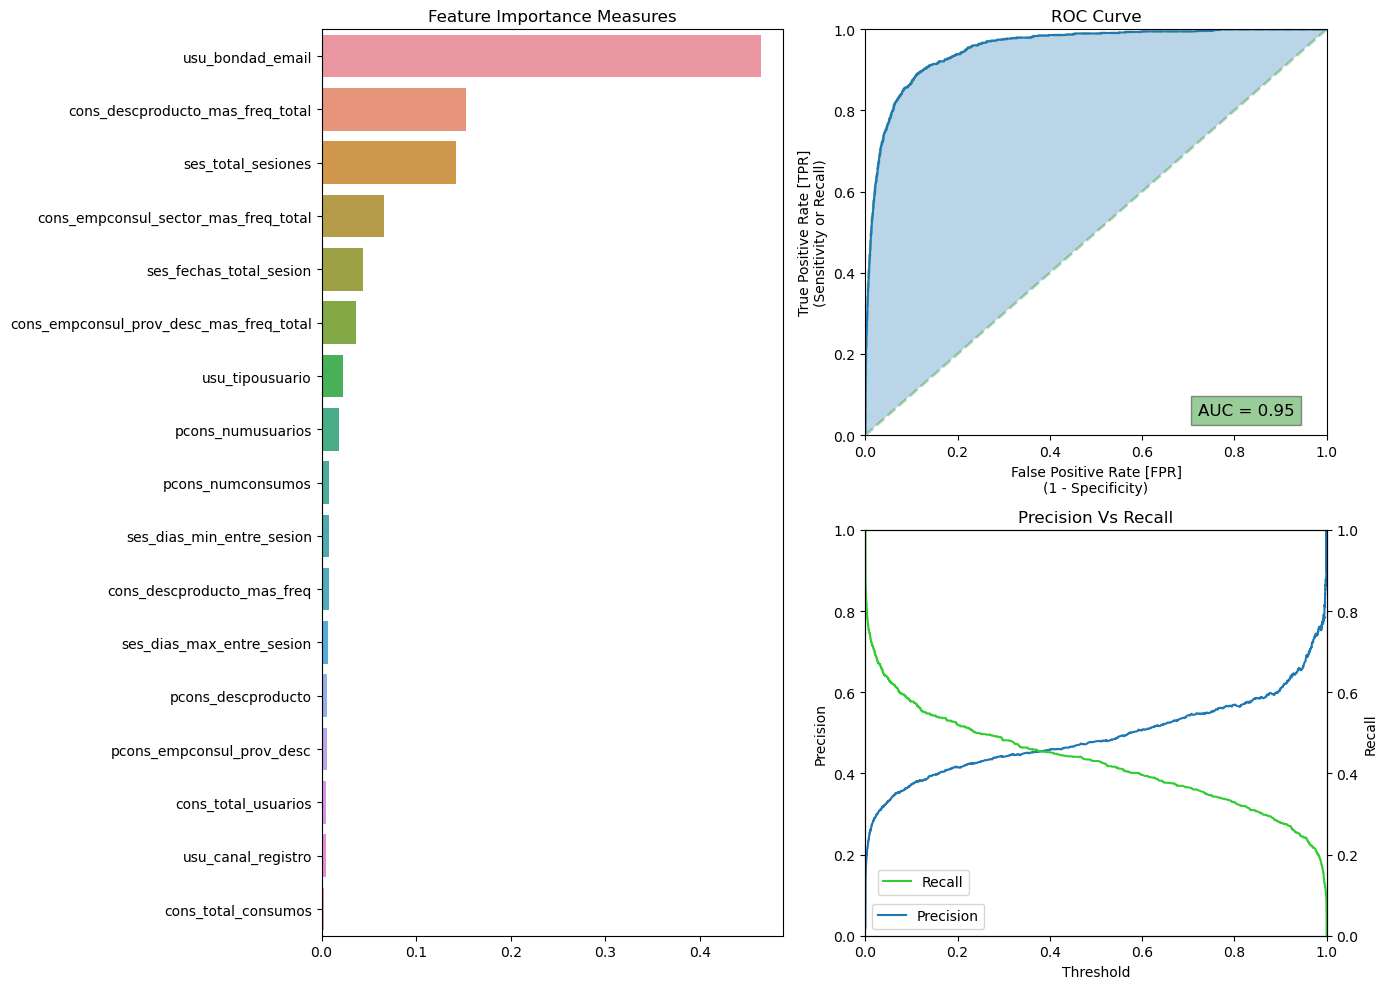

In [94]:
xgb_smoteenn_model, xgb_smoteenn_report = mpd.report(best_xgb_smoteenn, 
                                             'XGBoost SMOTEENN',
                                              X_train_res, 
                                              y_train_res, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [139]:
with open('data/reports/xgb_smoteenn_report.pkl', 'wb') as fp:
    pickle.dump(xgb_smoteenn_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 3.3.8. Model XGBoost y muestreo SMOTETomek

In [95]:
X_train_res, y_train_res = SMOTETomek().fit_resample(X_train, y_train)

In [96]:
print(np.unique(y_train_res, return_counts=True))

(array([0, 1], dtype=int64), array([97676, 97676], dtype=int64))


In [97]:
search_space = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.3, 1)
}
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
xgb = XGBClassifier(random_state=seed)
xgb_smotetomek = BayesSearchCV(xgb, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
xgb_smotetomek.fit(X_train_res, y_train_res)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      impor...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [98]:
best_xgb_smotetomek = xgb_smotetomek.best_estimator_
best_xgb_smotetomek.save_model('data/models/best_xgb_smotetomek.bin')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6514450031906109, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.0348142839429815, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=512, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=123, ...)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 195352 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.228 seconds
 Test

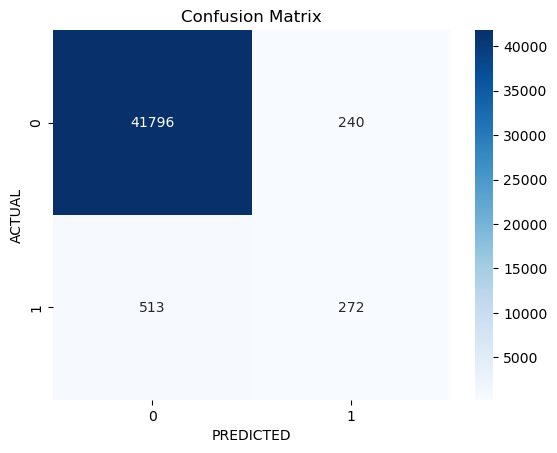


=======================================> PLOTS <=========================================



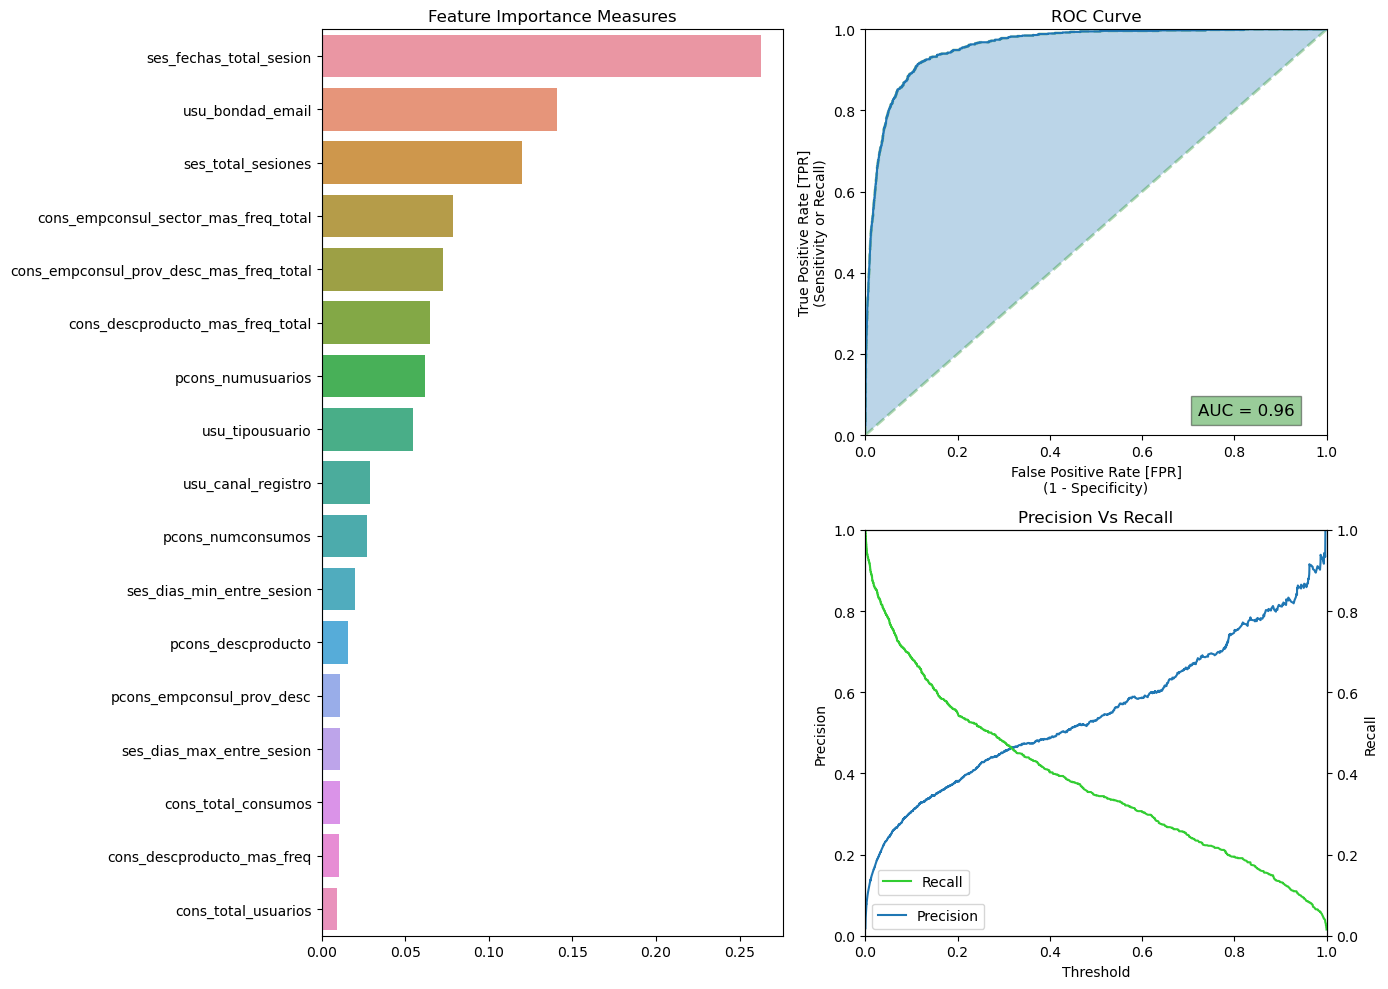

In [99]:
xgb_smotetomek_model, xgb_smotetomek_report = mpd.report(best_xgb_smotetomek, 
                                             'XGBoost SMOTETomek',
                                              X_train_res, 
                                              y_train_res, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [138]:
with open('data/reports/xgb_smotetomek_report.pkl', 'wb') as fp:
    pickle.dump(xgb_smotetomek_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# 4. Generación de modelos predictivos basado en métodos de ensamble

## 4.1. Selección modelo base

En esta sección se desarrolla el segundo método para la generación de modelos  predictivos basados en ensamble. Los modelos de ensemble aplicados a clases desbalanceadas están diseñados para abordar problemas de clasificación donde una o más clases están subrepresentadas en el conjunto de datos. Estos modelos combinan múltiples algoritmos de aprendizaje para mejorar la precisión y la robustez, particularmente en la identificación de la clase minoritaria. La clave de su eficacia radica en la diversidad de los modelos individuales y en las técnicas específicas utilizadas para equilibrar la distribución de clases, ya sea mediante la generación de muestras sintéticas, el submuestreo de la clase mayoritaria o el sobremuestreo de la clase minoritaria. 

In [58]:
def get_models():
    """
    Devuelve una lista de modelos de clasificación y muestreo y sus nombres asociados.

    Salida:
    - Una tupla que contiene dos listas:
      1. Una lista de modelos de clasificación (instancias de los clasificadores).
      2. Una lista de nombres asociados a cada modelo.
    """ 
    models, names = list(), list()
    # RUS
    models.append(RUSBoostClassifier(random_state=seed))
    names.append('RUS')
    # EEC
    models.append(EasyEnsembleClassifier(random_state=seed))
    names.append('EEC')    
    # BBC
    models.append(BalancedBaggingClassifier(random_state=seed))
    names.append('BBC')      
    # BRFC
    models.append(BalancedRandomForestClassifier(random_state=seed))
    names.append('BRFC')       
    
    # OverBoostC
    models.append(OverBoostClassifier(random_state=seed))
    names.append('OBOC')   
    # SBoostC
    models.append(SMOTEBoostClassifier(random_state=seed))
    names.append('SBOC')   
    # OBaggingC
    models.append(OverBaggingClassifier(random_state=seed))
    names.append('OBC')  
    # SBC
    models.append(SMOTEBaggingClassifier(random_state=seed))
    names.append('SBC')      
    
    return models, names

In [122]:
models, names = get_models()
results_train = list()
results_test = list()

for i in range(len(models)):
    scores_train = evaluate_model(X_train_, y_train, models[i])
    scores_test = evaluate_model(X_test_, y_test, models[i])
    results_train.append(scores_train)
    results_test.append(scores_test)    

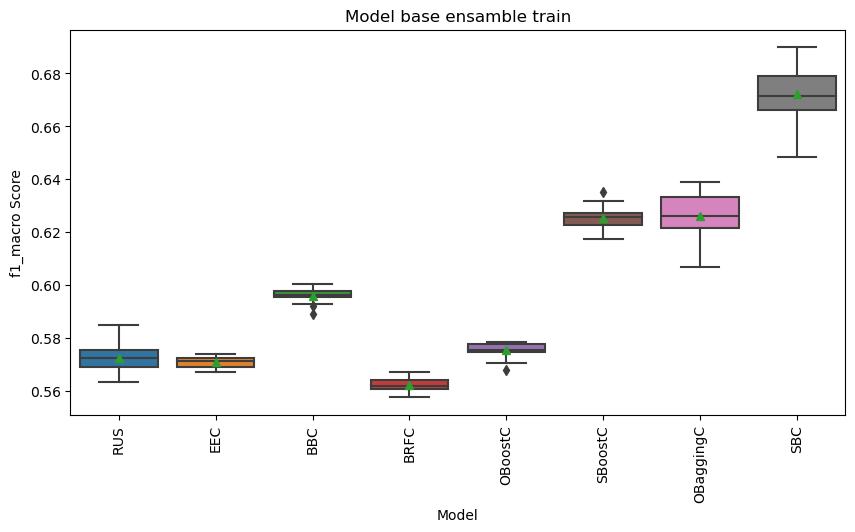

In [235]:
box_plot_models(results_train, names, primary_metric, 90, 'Model base ensamble train')

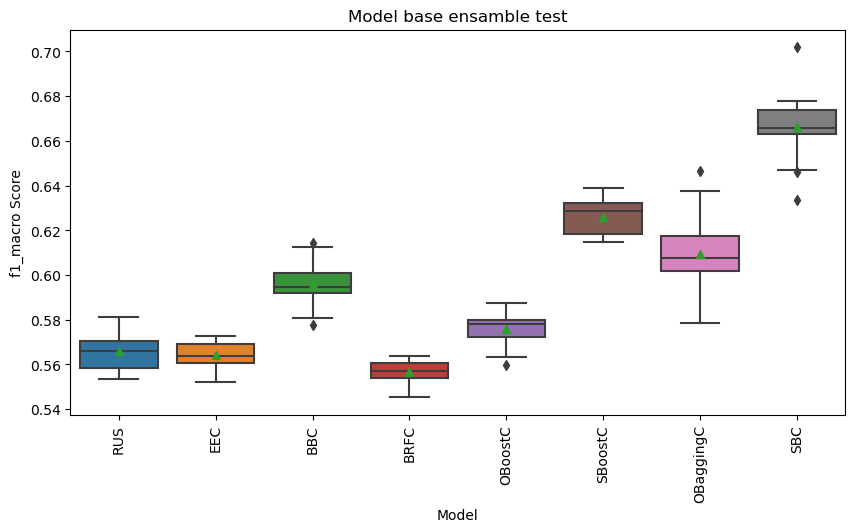

In [234]:
box_plot_models(results_test, names, primary_metric, 90, 'Model base ensamble test')

In [230]:
model_ensemble = dict()
model_ensemble['train'] = results_train
model_ensemble['test'] = results_test

model_ensemble_train = pd.DataFrame(model_ensemble['train']).T
model_ensemble_train.columns = names
model_ensemble_test = pd.DataFrame(model_ensemble['test']).T
model_ensemble_test.columns = names

In [ ]:
model_ensemble_train.to_csv('data/model_ensemble_train.csv')
model_ensemble_test.to_csv('data/model_ensemble_test.csv')

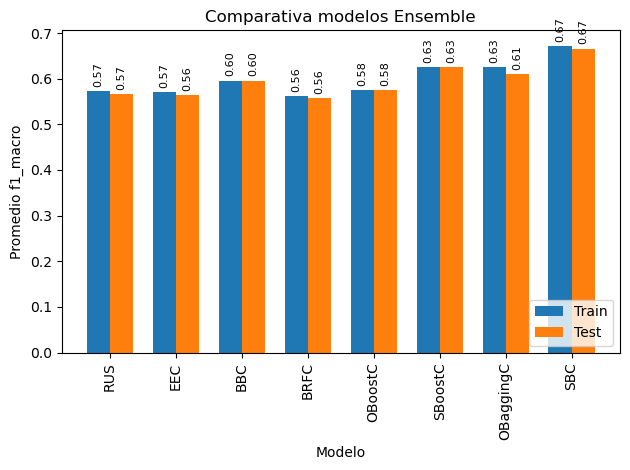

In [241]:
graph_train_test_models(train=model_ensemble_train, 
                        test=model_ensemble_test, 
                        metric_name=primary_metric, 
                        angle_rotate=90,
                        title_fig='Comparativa modelos Ensemble')

## 4.2. Optimización de hyperparámetros

Definidos los mejores modelos, el paso siguiente es optimizar los hiperparámetros y evaluar los modelos. Para esto se usará la técnica de optimización bayesiana y validación cruzada estratificada. 

### 4.2.1. Model Ensemble SMOTEBaggingClassifier

In [236]:
search_space = {
    'estimator__max_depth': Integer(5, 15),
    'n_estimators': Integer(100, 1000),
    'bootstrap': Categorical([True, False]),
    'bootstrap_features': Categorical([True, False]),
    'max_samples': Real(0.01, 1.0, 'log-uniform'),
    'max_features': Real(0.01, 1.0, 'log-uniform'),
    'k_neighbors' : Integer(2, 100)
}

cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
sbc = SMOTEBaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs=n_jobs, random_state=seed)
sbc_ens = BayesSearchCV(sbc, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
sbc_ens.fit(X_train, y_train)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=123),
              estimator=SMOTEBaggingClassifier(estimator=DecisionTreeClassifier(),
                                               n_jobs=6, random_state=123),
              n_iter=32, n_jobs=6, random_state=123, scoring='f1_macro',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'bootstrap_features': Categorical(categories...
                             'estimator__max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'k_neighbors': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_samples': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [237]:
best_sbc_ens = sbc_ens.best_estimator_
dump(best_sbc_ens, 'data/models/best_sbc_ens.joblib')

['data/models/best_sbc_ens.joblib']

SMOTEBaggingClassifier(bootstrap=False, bootstrap_features=True,
                       estimator=DecisionTreeClassifier(max_depth=15),
                       k_neighbors=2, n_estimators=1000, n_jobs=6,
                       random_state=123)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 99915 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 6.956 seconds
 Testing Time: 4.161 seconds
---------------------------------------------
Train Accuracy:  0.9853675624280639
 Test Accuracy:  0.9757128511711544
---------------------------------------------
Train F1 Score:  0.6766917293233082
 Test F1 Score:  0.3981481481481482

Train Precision Score:  0.5683506686478454
 Test Precision Score:  0.3647932131495228

Train Recall Score:  0.8360655737704918
 Test Recall Score:  0.43821656050955415

---------------------------------------------
 Area Under ROC (test):  0.9444177208131579
---------

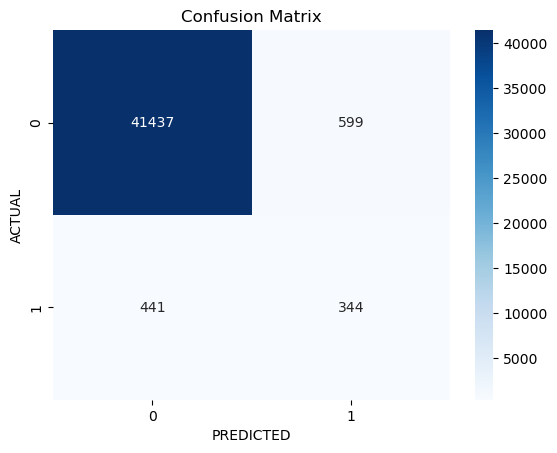


=======================================> PLOTS <=========================================



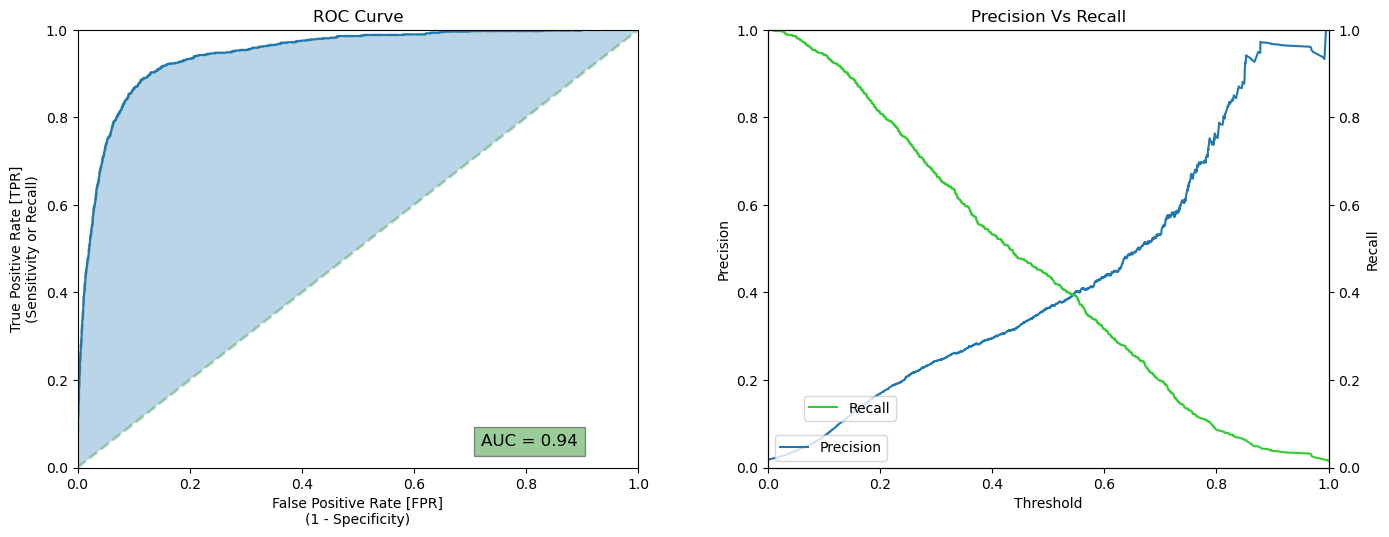

In [239]:
sbc_ens_model, sbc_ens_report = mpd.report(best_sbc_ens,
                                             'SBC',
                                              X_train, 
                                              y_train, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [242]:
with open('data/reports/sbc_ens_report.pkl', 'wb') as fp:
    pickle.dump(sbc_ens_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


### 4.2.2. Model Ensemble OverBaggingClassifier

In [19]:
search_space = {
    'estimator__max_depth': Integer(5, 15),
    'n_estimators': Integer(50, 500),
    'bootstrap': Categorical([True, False]),
    'bootstrap_features': Categorical([True, False]),
    'max_samples': Real(0.01, 1.0, 'log-uniform'),
    'max_features': Real(0.01, 1.0, 'log-uniform'),
}

cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
obaggingc = OverBaggingClassifier(estimator=DecisionTreeClassifier(), random_state=seed, n_jobs=n_jobs)
obaggingc_ens = BayesSearchCV(obaggingc, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
obaggingc_ens.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
              estimator=OverBaggingClassifier(estimator=DecisionTreeClassifier(),
                                              n_jobs=6, random_state=123),
              n_iter=32, n_jobs=6, random_state=123, scoring='f1_macro',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'bootstrap_features': Categorical(categories=(True, False), prior=None),
                             'estimator__max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_samples': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize')})

In [20]:
best_obaggingc_ens= obaggingc_ens.best_estimator_
dump(best_obaggingc_ens, 'data/models/best_sboostc_ens.joblib')

['data/models/best_sboostc_ens.joblib']

OverBaggingClassifier(bootstrap=False, bootstrap_features=True,
                      estimator=DecisionTreeClassifier(max_depth=15),
                      max_samples=0.2370471811426949, n_estimators=349,
                      n_jobs=6, random_state=123)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 99915 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 2.172 seconds
 Testing Time: 1.241 seconds
---------------------------------------------
Train Accuracy:  0.9819846869839364
 Test Accuracy:  0.9757595572265945
---------------------------------------------
Train F1 Score:  0.5391705069124424
 Test F1 Score:  0.30522088353413657

Train Precision Score:  0.5072254335260116
 Test Precision Score:  0.3215796897038082

Train Recall Score:  0.5754098360655737
 Test Recall Score:  0.29044585987261146

---------------------------------------------
 Area Under ROC (test):  0.9312252827876

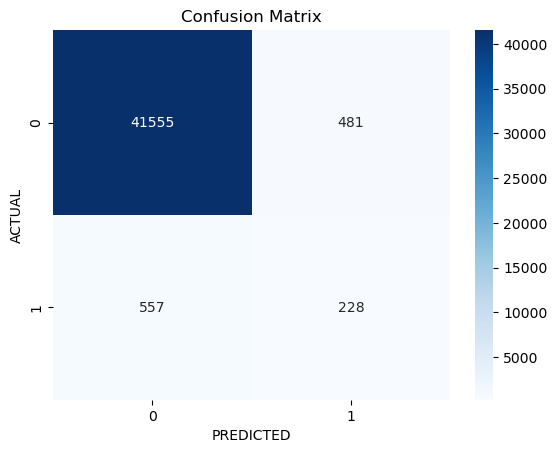


=======================================> PLOTS <=========================================



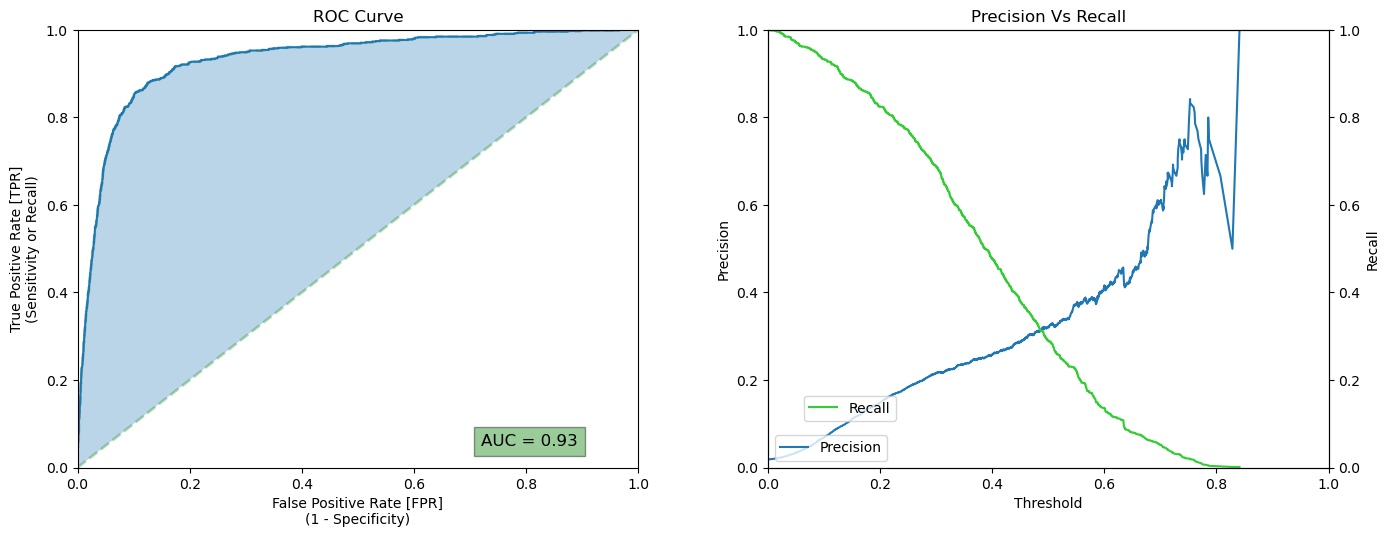

In [21]:
obaggingc_ens_model, obaggingc_ens_report = mpd.report(best_obaggingc_ens,
                                                 'ObaggingC',
                                                  X_train, 
                                                  y_train, 
                                                  X_test,
                                                  y_test,
                                                  display_scores=primary_eval_metric, 
                                                  importance_plot=True, 
                                                  confusion_labels=confusion_labels, 
                                                  feature_labels=feature_labels, 
                                                  verbose=True)

In [22]:
with open('data/reports/obaggingc_ens_report.pkl', 'wb') as fp:
    pickle.dump(obaggingc_ens_report, fp)
    print('dictionary saved successfully to file')                                              

dictionary saved successfully to file


### 4.2.3. Model Ensemble BalancedBaggingClassifier

In [167]:
# from sklearn.metrics import make_scorer, average_precision_score
# pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

search_space = {
    'estimator__max_depth': Integer(5, 15),
    'n_estimators': Integer(100, 1000),
    'bootstrap': Categorical([True, False]),
    'bootstrap_features': Categorical([True, False]),
    'sampling_strategy' : Categorical(['majority', 'not minority', 'not majority']),    
    'max_samples': Real(0.01, 1.0, 'log-uniform'),
    'max_features': Real(0.01, 1.0, 'log-uniform')
}

cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
bbagging = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(), random_state=seed)
bagging_ens = BayesSearchCV(bbagging, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
bagging_ens.fit(X_train, y_train)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                                  random_state=123),
              n_iter=32, n_jobs=6, random_state=123, scoring='f1_macro',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'bootstrap_features': Categorical(categories=(True...
                             'estimator__max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_samples': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'sampling_strategy': Categorical(categories=('majority', 'not minority', 'not majority'), prior=None)})

In [172]:
best_bagging_ens = bagging_ens.best_estimator_
dump(best_bagging_ens, 'data/models/best_bagging_ens.joblib')

['data/models/best_bagging_ens.joblib']

BalancedBaggingClassifier(bootstrap_features=True,
                          estimator=DecisionTreeClassifier(max_depth=15),
                          max_features=0.7439219198775794, n_estimators=1000,
                          random_state=123, sampling_strategy='majority')

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 99915 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 14.944 seconds
 Testing Time: 6.394 seconds
---------------------------------------------
Train Accuracy:  0.914857628984637
 Test Accuracy:  0.9104644917213517
---------------------------------------------
Train F1 Score:  0.2987387684444811
 Test F1 Score:  0.26495398773006135

Train Precision Score:  0.1759052519172896
 Test Precision Score:  0.1559467388851275

Train Recall Score:  0.9901639344262295
 Test Recall Score:  0.8802547770700637

---------------------------------------------
 Area Under ROC (tes

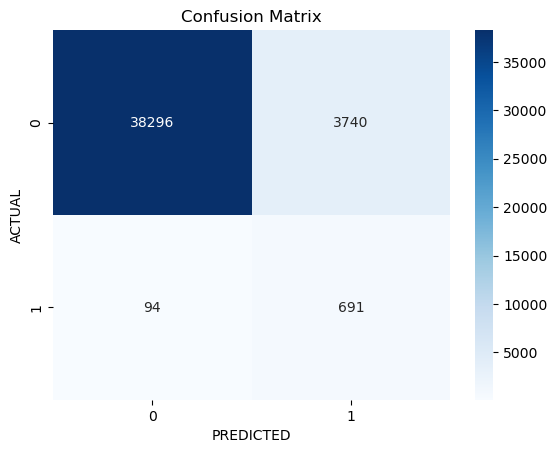


=======================================> PLOTS <=========================================



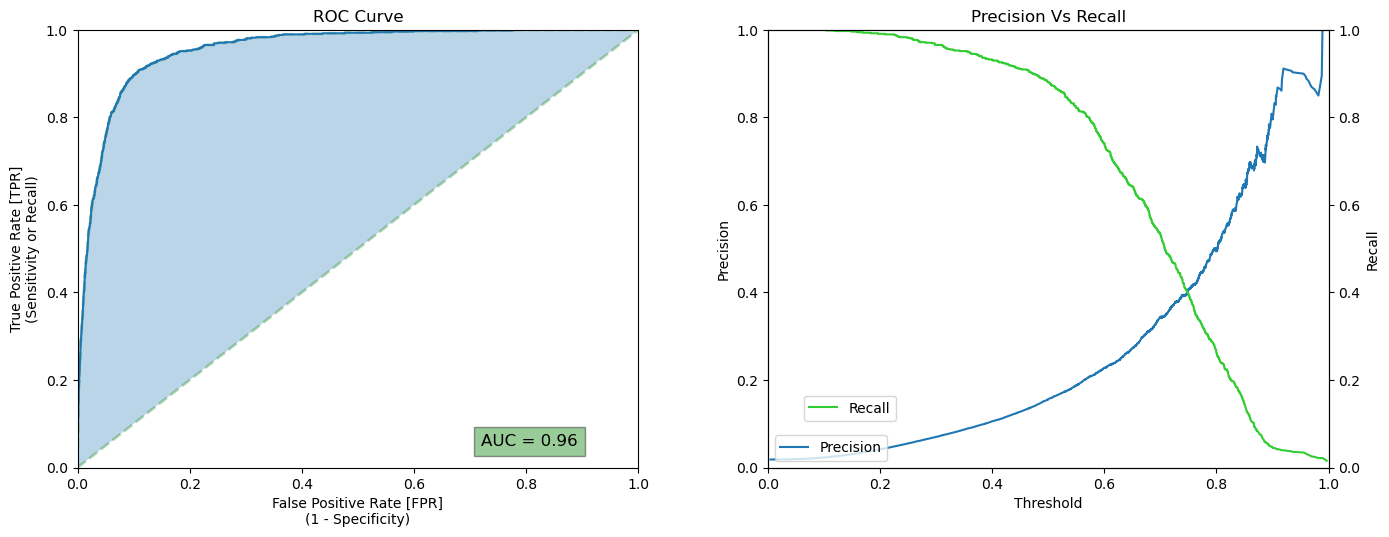

In [173]:
bagging_ens_model, bagging_ens_report = mpd.report(best_bagging_ens,
                                             'Balanced Bagging Classifier',
                                              X_train, 
                                              y_train, 
                                              X_test,
                                              y_test,
                                              display_scores=primary_eval_metric, 
                                              importance_plot=True, 
                                              confusion_labels=confusion_labels, 
                                              feature_labels=feature_labels, 
                                              verbose=True)

In [174]:
with open('data/reports/bagging_ens_report.pkl', 'wb') as fp:
    pickle.dump(bagging_ens_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# 5. Generación de modelos predictivos basado en Cost-sensitive learning

En esta sección se desarrolla el tercer método para la generación de modelos predictivos basados en Cost-sensitive learning (CSL). Los modelos predictivos basados en el aprendizaje sensible a los costos (Cost-sensitive learning) son una técnica avanzada en el campo del aprendizaje automático, específicamente diseñada para tratar con problemas de clasificación donde las clases están altamente desbalanceadas. En este contexto, el aprendizaje sensible a los costos se concentra en minimizar no solo el error de clasificación en general, sino también en reducir el costo asociado con los errores de clasificación, donde diferentes tipos de errores pueden tener diferentes costos asociados.

Aclarado el concepto CSL, a continuación se entrenan dos de los modelos sobre los cuales se puede aplicar la técnica en mención, como son XGB y LGBM. El entrenamiento y validación se hace mediante optimización bayesiana y validación cruzada estratificada.

## 5.1. LightGBM Cost-sensitive learning

In [190]:
search_space = {
    'learning_rate': Real(0.01, 0.5),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 20),
    'scale_pos_weight': Categorical([1, 10, 25, 50, 75, 99, 100, 1000])
}

lgbm = LGBMClassifier(random_state=seed)
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
lgbm_cs = BayesSearchCV(lgbm, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
lgbm_cs.fit(X_train, y_train)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=LGBMClassifier(random_state=123), n_iter=32, n_jobs=6,
              random_state=123, scoring='f1_macro',
              search_spaces={'learning_rate': Real(low=0.01, high=0.5, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=20, high=150, prior='uniform', transform='normalize'),
                             'scale_pos_weight': Categorical(categories=(1, 10, 25, ..., 99, 100, 1000), prior=None)})

In [191]:
best_lgbm_cs = lgbm_cs.best_estimator_
best_lgbm_cs.booster_.save_model('data/models/best_lgbm_cs.bin')

LGBMClassifier(learning_rate=0.14216044410214146, max_depth=3, n_estimators=967,
               num_leaves=115, random_state=123, scale_pos_weight=1)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 99915 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.323 seconds
 Testing Time: 0.115 seconds
---------------------------------------------
Train Accuracy:  0.9899114247110044
 Test Accuracy:  0.9849840031760118
---------------------------------------------
Train F1 Score:  0.6430594900849859
 Test F1 Score:  0.4413553431798436

Train Precision Score:  0.9134808853118712
 Test Precision Score:  0.6939890710382514

Train Recall Score:  0.4961748633879781
 Test Recall Score:  0.3235668789808917

---------------------------------------------
 Area Under ROC (test):  0.9617004502661656
---------------------------------------------
Model Memory Size: 933.22 kB

============================

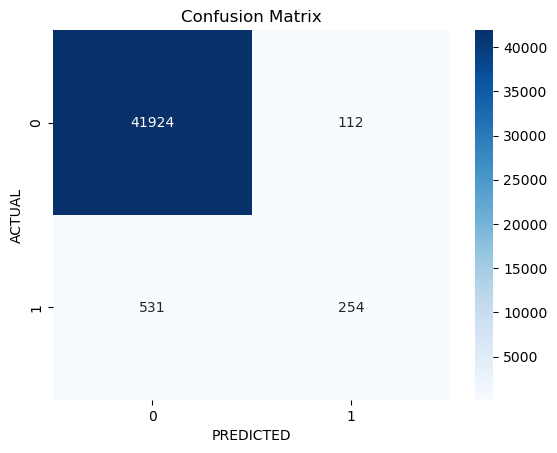


=======================================> PLOTS <=========================================



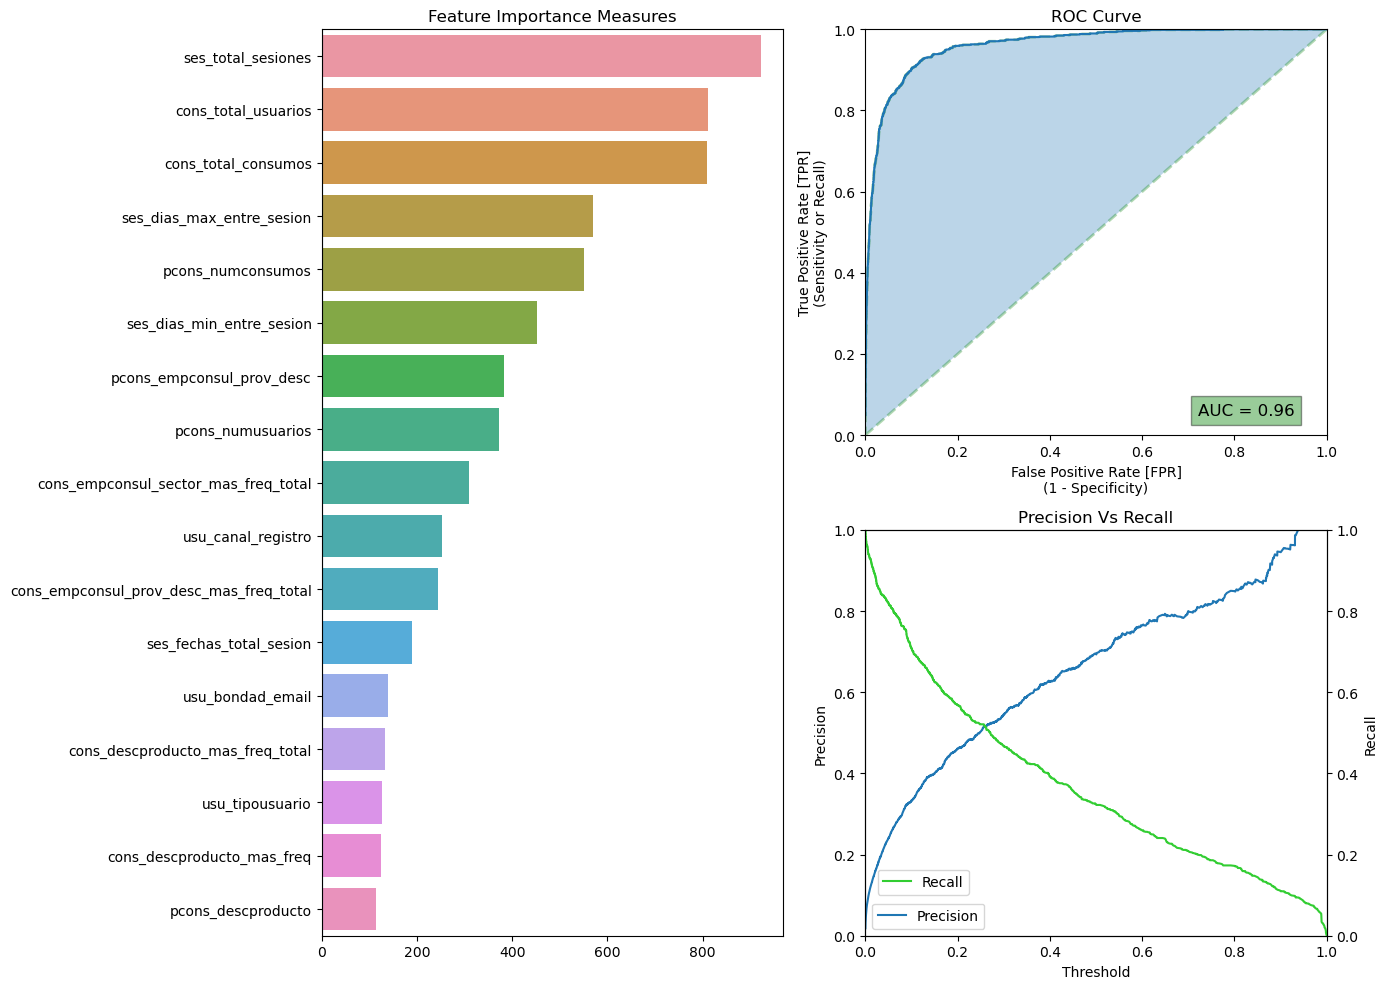

In [192]:
lgbm_cs_model, lgbm_cs_report = mpd.report(best_lgbm_cs, 
                                      'LGBM Cost-sensitive',
                                      X_train, 
                                      y_train, 
                                      X_test,
                                      y_test,
                                      display_scores=primary_eval_metric, 
                                      importance_plot=True, 
                                      confusion_labels=confusion_labels, 
                                      feature_labels=feature_labels, 
                                      verbose=True)

In [201]:
with open('data/reports/lgbm_cs_report.pkl', 'wb') as fp:
    pickle.dump(lgbm_cs_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


## 5.2. XGBoost Cost-sensitive learning

In [179]:
search_space = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.3, 1),
    'scale_pos_weight': Categorical([1, 10, 25, 50, 75, 99, 100, 1000])
}

cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
xgb = XGBClassifier(random_state=seed)
xgb_cs = BayesSearchCV(xgb, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)
xgb_cs.fit(X_train, y_train)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=123),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      impor...
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'scale_pos_weight': Categorical(categories=(1, 10, 25, ..., 99, 100, 1000), prior=None),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [180]:
best_xgb_cs = xgb_cs.best_estimator_
best_xgb_cs.save_model('data/models/best_xgb_cs.bin')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.840415752656776, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, n_estimators=863, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=123, ...)

==================================> TRAIN-TEST DETAILS <====================================

Train Size: 99915 samples
 Test Size: 42821 samples
---------------------------------------------
Training Time: 0.131 seconds
 Testing Time: 0.045

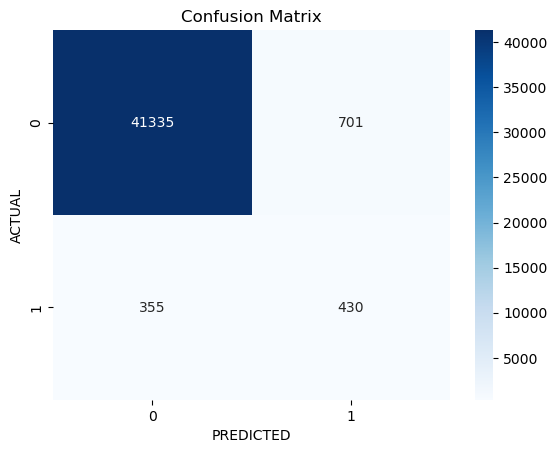


=======================================> PLOTS <=========================================



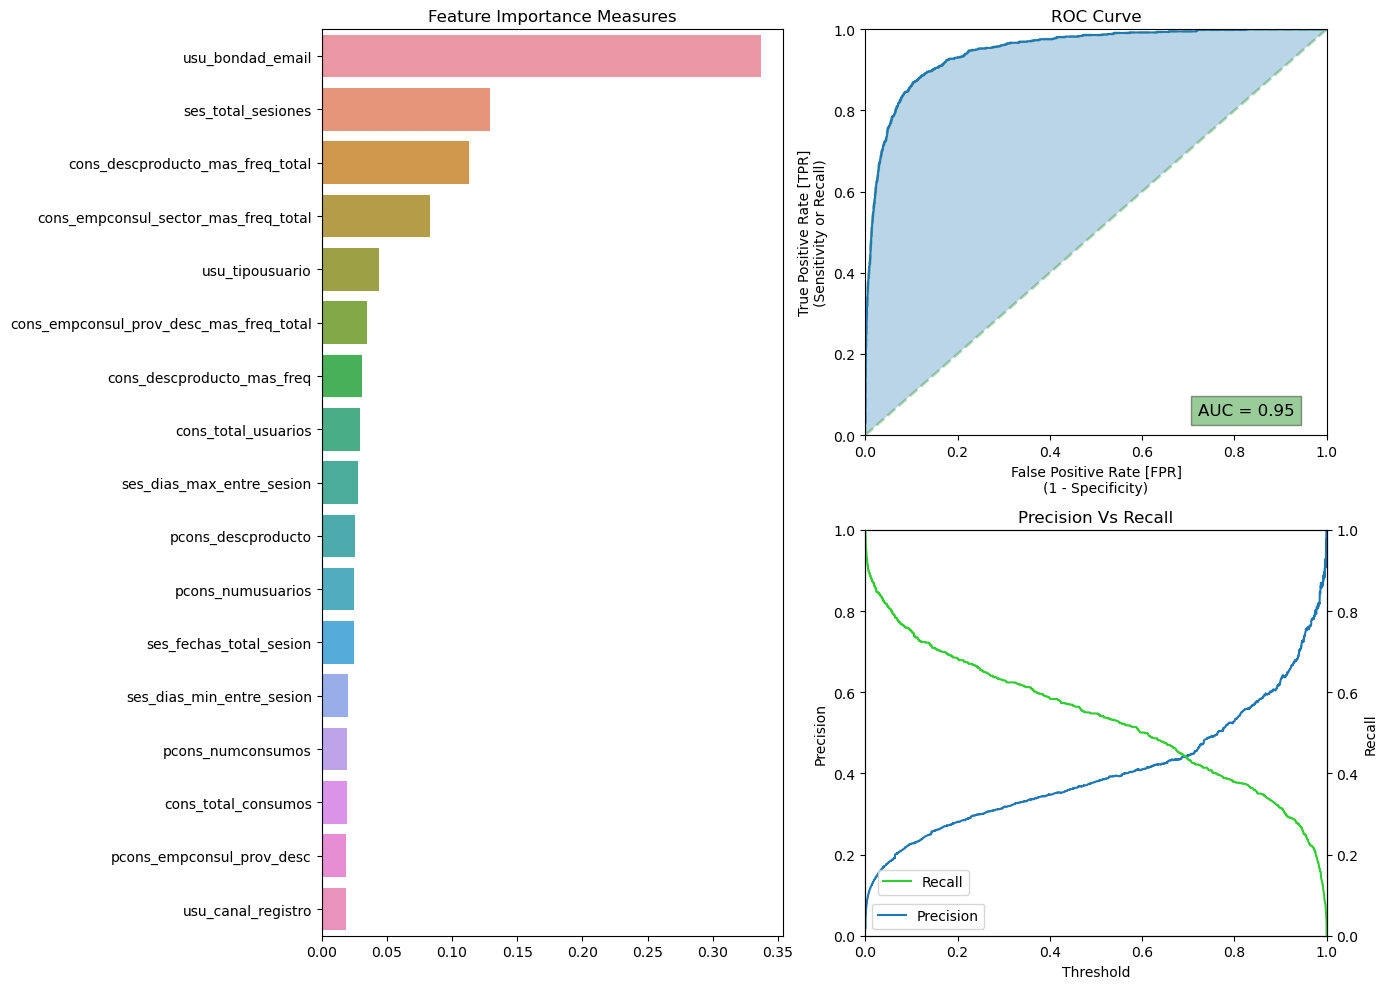

In [181]:
xgb_cs_model, xgb_cs_report = mpd.report(best_xgb_cs,
                                      'XBoost Cost-sensitive',
                                      X_train, 
                                      y_train, 
                                      X_test,
                                      y_test,
                                      display_scores=primary_eval_metric, 
                                      importance_plot=True, 
                                      confusion_labels=confusion_labels, 
                                      feature_labels=feature_labels, 
                                      verbose=True)

In [183]:
with open('data/reports/xgb_cs_report.pkl', 'wb') as fp:
    pickle.dump(xgb_cs_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# 6. Generación de modelo predictivo basado en voting

En vista que las predicciones de LGBM CSL tienen la precisión alta, respecto a los otros modelos y BBC tiene un recall razonablemente alto, se plantea un modelo de voting para equilibrar e intentar mejorar las predicciones

In [196]:
estimator = []
estimator.append(('bagging_ens', best_bagging_ens))
estimator.append(('lgbm_cs', best_lgbm_cs))
voting = VotingClassifier(estimators=estimator, voting='soft', n_jobs=n_jobs)

search_space = {'weights': [Real(0.1, 2.0, prior='uniform'), Real(0.1, 2.0, prior='uniform')]}
cv = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
voting_opt = BayesSearchCV(voting, search_space, n_iter=32, scoring=primary_metric, cv=cv, n_jobs=n_jobs, random_state=seed)

voting_opt.fit(X_train, y_train)

VotingClassifier(estimators=[('bagging_ens',
                              BalancedBaggingClassifier(bootstrap_features=True,
                                                        estimator=DecisionTreeClassifier(max_depth=15),
                                                        max_features=0.7439219198775794,
                                                        n_estimators=1000,
                                                        random_state=123,
                                                        sampling_strategy='majority')),
                             ('lgbm_cs',
                              LGBMClassifier(learning_rate=0.14216044410214146,
                                             max_depth=3, n_estimators=967,
                                             num_leaves=115, random_state=123,
                                             scale_pos_weight=1))],
                 n_jobs=6, voting='soft', weights=[1.25, 1])

In [ ]:
best_voting = voting_opt.best_estimator_
best_voting.save_model('data/models/best_voting.bin')

VotingClassifier(estimators=[('bagging_ens',
                              BalancedBaggingClassifier(bootstrap_features=True,
                                                        estimator=DecisionTreeClassifier(max_depth=15),
                                                        max_features=0.7439219198775794,
                                                        n_estimators=1000,
                                                        random_state=123,
                                                        sampling_strategy='majority')),
                             ('lgbm_cs',
                              LGBMClassifier(learning_rate=0.14216044410214146,
                                             max_depth=3, n_estimators=967,
                                             num_leaves=115, random_state=123,
                                             scale_pos_weight=1))],
                 n_jobs=6, voting='soft', weights=[1.25, 1])

==================================> TR

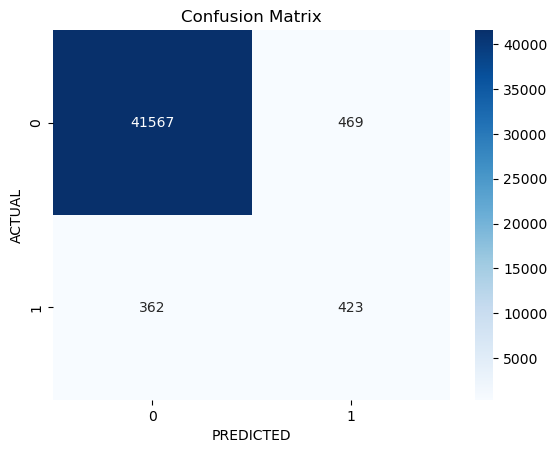


=======================================> PLOTS <=========================================



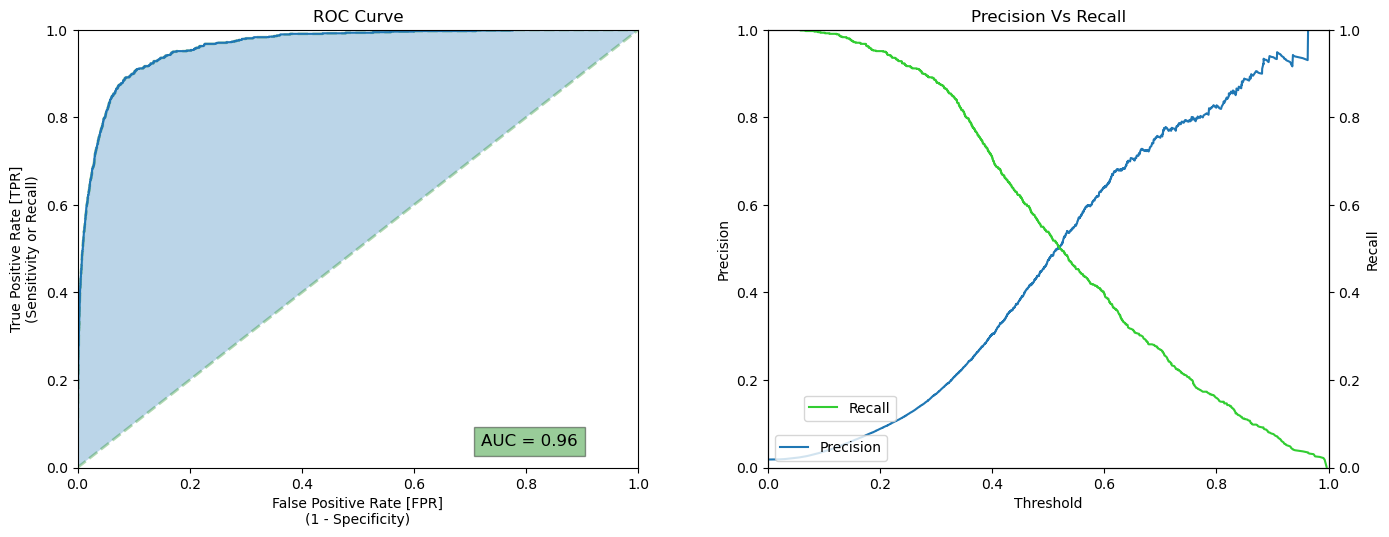

In [197]:
voting_model, voting_report = mpd.report(best_voting,
                                         'Voting bagging_ens lgbm_cs',
                                          X_train, 
                                          y_train, 
                                          X_test,
                                          y_test,
                                          display_scores=primary_eval_metric, 
                                          importance_plot=True, 
                                          confusion_labels=confusion_labels, 
                                          feature_labels=feature_labels, 
                                          verbose=True)

In [199]:
with open('data/reports/voting_report.pkl', 'wb') as fp:
    pickle.dump(voting_report, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# 7. Resumen métricas modelos predictivos

In [2]:
def read_pickle(filename):
    """
    Lee y carga un objeto desde un archivo pickle.

    Parámetros:
    - filename (str): El nombre del archivo pickle desde el cual se va a cargar el objeto.

    Salida:
    - El objeto cargado desde el archivo pickle.    
    """
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()
    return data

lgbm_svmsmote_report = read_pickle('data/reports/lgbm_svmsmote_report.pkl')
lgbm_blsmote_report = read_pickle('data/reports/lgbm_blsmote_report.pkl')
lgbm_smoteenn_report = read_pickle('data/reports/lgbm_smoteenn_report.pkl')
xgb_adasyn_report = read_pickle('data/reports/xgb_adasyn_report.pkl')
xgb_svmsmote_report = read_pickle('data/reports/xgb_svmsmote_report.pkl')
xgb_blsmote_report = read_pickle('data/reports/xgb_blsmote_report.pkl')
xgb_smoteenn_report = read_pickle('data/reports/xgb_smoteenn_report.pkl')
xgb_smotetomek_report = read_pickle('data/reports/xgb_smotetomek_report.pkl')
sbc_ens_report = read_pickle('data/reports/sbc_ens_report.pkl')
obaggingc_ens_report = read_pickle('data/reports/obaggingc_ens_report.pkl')
bagging_ens_report = read_pickle('data/reports/bagging_ens_report.pkl')
lgbm_cs_report = read_pickle('data/reports/lgbm_cs_report.pkl')
xgb_cs_report = read_pickle('data/reports/xgb_cs_report.pkl')
voting_report = read_pickle('data/reports/voting_report.pkl')

In [45]:
report_list = [lgbm_svmsmote_report, lgbm_blsmote_report, lgbm_smoteenn_report, 
               xgb_adasyn_report, xgb_svmsmote_report, xgb_blsmote_report,
               xgb_smoteenn_report, xgb_smotetomek_report, 
               sbc_ens_report, obaggingc_ens_report, bagging_ens_report,
               lgbm_cs_report, xgb_cs_report, 
               voting_report]

compare_table = mpd.compare_models(clf_reports=report_list, 
                                   score=primary_eval_metric[0].__name__).drop(['Overfitting', 'Support', 
                                                                                'Train f1_score', 'Test f1_score'], axis=1)

In [47]:
rename_index = ["LGBM SVMSMOTE", "LGBM BLSMOTE", "LGBM SMOTEENN", "XGB ADASYN", 
                "XGB SVMSMOTE", "XGB BLSMOTE", "XGB SMOTEENN", "XGB SMOTETomek", 
                "SBC", "OBC", "BBC", "LGBM CSL", 
                "XGB CSL", "VOTING"]

compare_table.index = rename_index

compare_table

,ROC Area,Precision,Recall,F1-score
LGBM SVMSMOTE,0.952605,0.614512,0.345223,0.442088
LGBM BLSMOTE,0.953579,0.590234,0.35414,0.442675
LGBM SMOTEENN,0.959671,0.51505,0.392357,0.445409
XGB ADASYN,0.952878,0.565217,0.347771,0.430599
XGB SVMSMOTE,0.957964,0.565966,0.37707,0.452599
XGB BLSMOTE,0.957986,0.538899,0.361783,0.432927
XGB SMOTEENN,0.953982,0.479433,0.430573,0.453691
XGB SMOTETomek,0.958952,0.53125,0.346497,0.419429
SBC,0.944418,0.364793,0.438217,0.398148
OBC,0.931225,0.32158,0.290446,0.305221


In [48]:
compare_table = compare_table.reset_index()

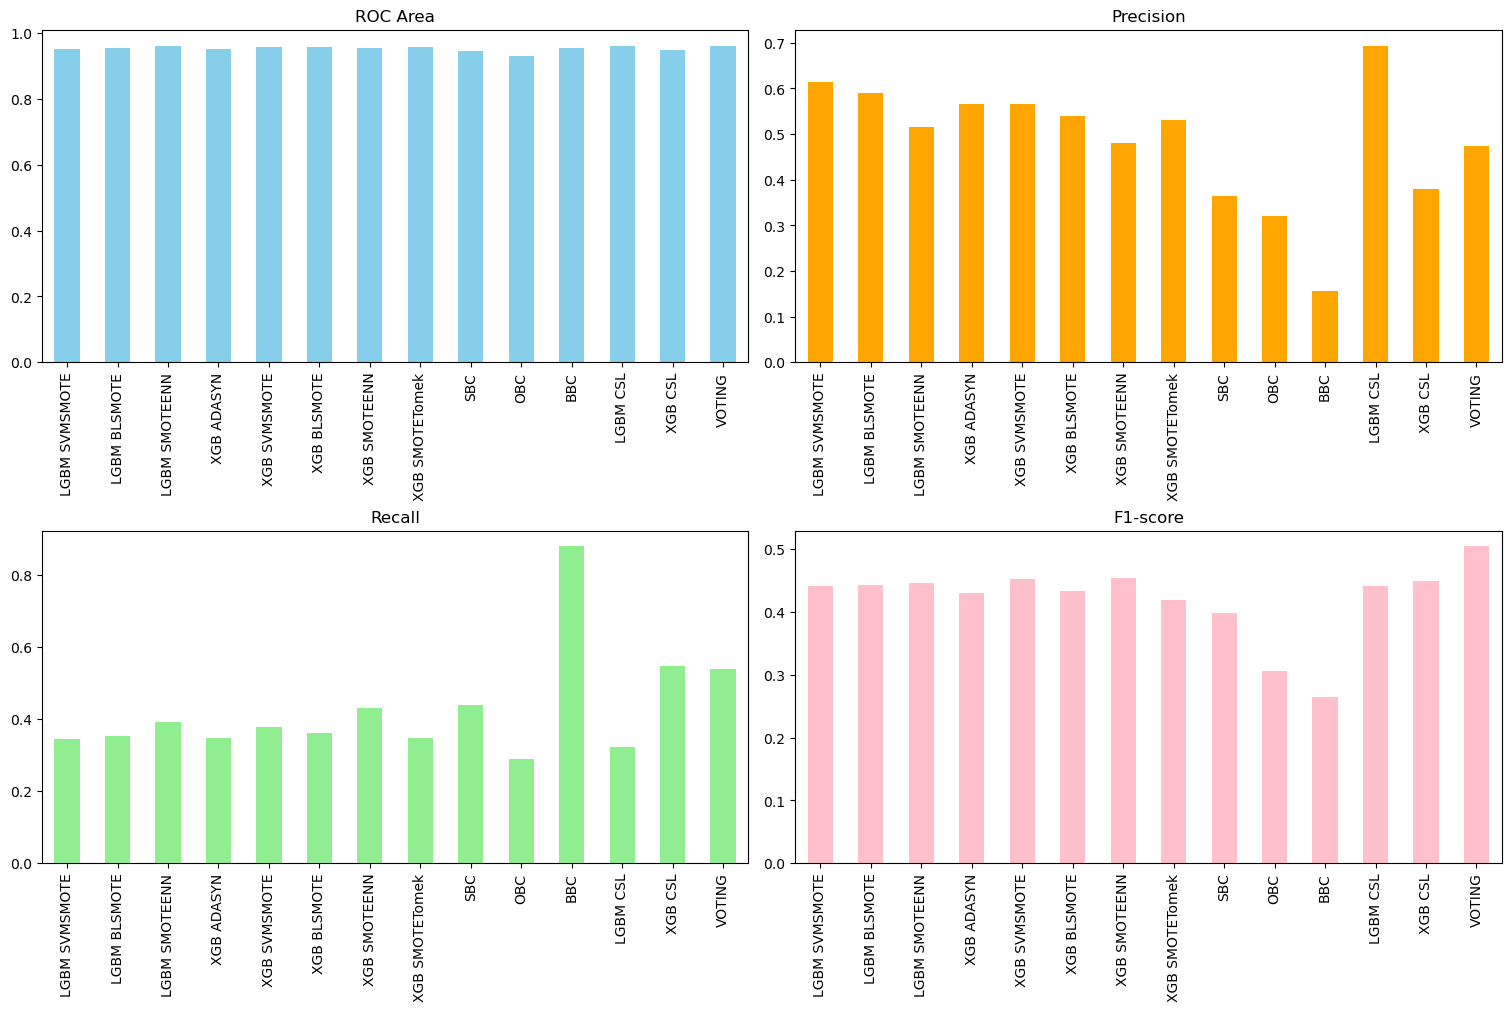

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)
metrics = ["ROC Area", "Precision", "Recall", "F1-score"]
colors = ['skyblue', 'orange', 'lightgreen', 'pink']

for i, metric in enumerate(metrics):
    ax = axs[i//2, i%2]
    compare_table.plot(x='index', y=metric, kind='bar', ax=ax, color=colors[i], legend=False)
    ax.set_title(f'{metric}')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')

plt.show()

# 8. Importancia de características

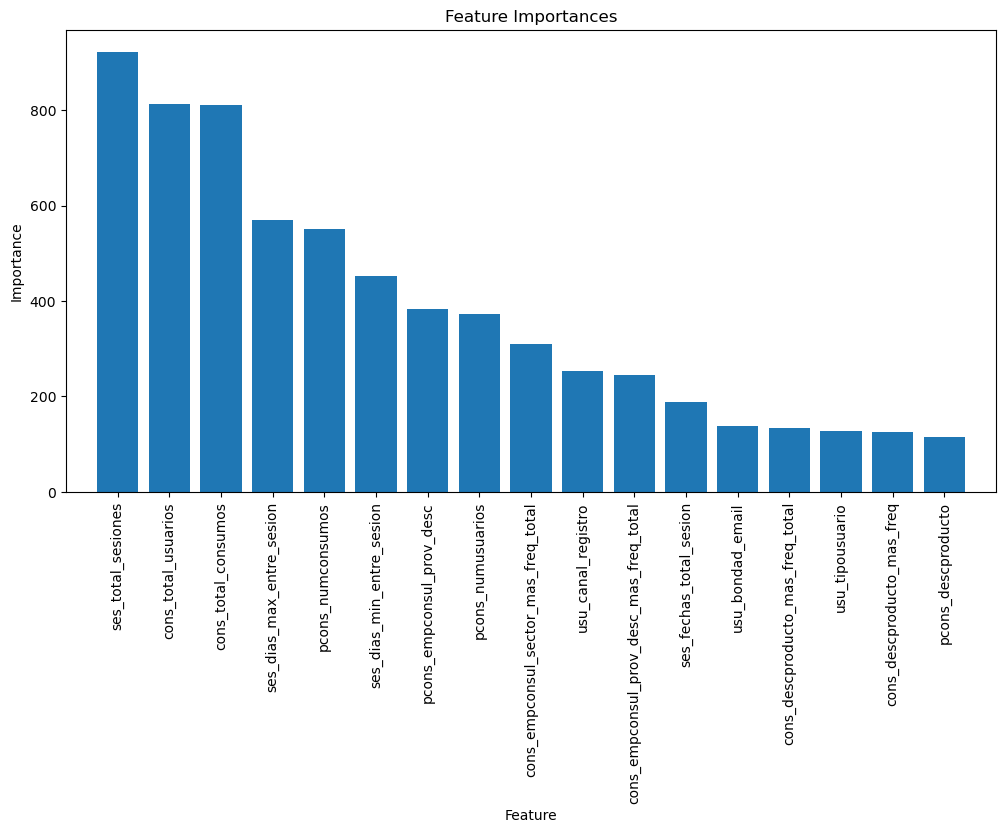

In [202]:
feat_imp = best_lgbm_cs.feature_importances_
feature_names = X_train.columns

indices = np.argsort(feat_imp)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feat_imp[indices], align="center")

plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')

plt.show()

# 9. Conclusiones

<div class="alert alert-block alert-info">

En las secciones anteriores se desarrolló la tercera fase del componente experimental del TFM. 
Para la selección de características, se utilizó el método (RFE) para identificar las variables con mayor poder predictivo. Se seleccionó la métrica f1_macro para el entrenamiento de modelos debido al desbalance en la variable objetivo, favoreciendo así un rendimiento uniforme entre todas las clases y evitando el sesgo hacia la clase mayoritaria. Los modelos de referencia se entrenaron con validación cruzada estratificada y los resultados mostraron que XGBoost (XGB) tenía el mejor rendimiento promedio. Sobre este modelo se aplicó RFE, y las variables seleccionadas como más relevantes incluyen características descriptivas del producto, información de registro del usuario, y métricas de interacción del usuario con la sesión.

En relación con los modelos predictivos basados en métodos de muestreo, los modelos LGBM y XGB fueron identificados como los mejores modelos de referencia. Se aplicaron diversas técnicas de remuestreo, categorizadas en sobremuestreo, submuestreo y combinadas, y se evaluaron con validación cruzada estratificada. Los mejores resultados en f1_macro se observaron con las técnicas de sobremuestreo BLSMOTE, SVMSMOTE y SMOTEENN para LGBM y ADASYN, BLSMOTE, SVMSMOTE, SMOTEENN y SMOTETomek para XGB.

En relación con los modelos predictivos basados en métodos de ensamble, se exploró cómo los modelos de ensamble, que combinan múltiples algoritmos de aprendizaje, pueden mejorar la precisión y la robustez en la identificación de clases minoritarias. Los resultados demostraron que el SMOTE Bagging Classifier, Over Bagging Classifier y Balanced Bagging Classifier fueron los más equilibrados y efectivos según la métrica f1_macro.

Respecto a los modelos predictivos basados en (CSL), se entrenaron y validaron modelos CSL con XGB y LGBM, encontrando que XGB CSL tenía un mejor rendimiento general y LGBM CSL mostró una alta precisión.
    
En relación con el modelo predictivo basado en voting, se propuso un modelo de ensamble de votación combinando LGBM CSL y BBC, resultando en la mejor precisión y un alto recall, reflejado en el mejor puntaje F1, lo que indica un equilibrio óptimo entre identificar clientes y minimizar falsas alarmas.
</div> 

# Información de sesión

In [26]:
import session_info
session_info.show()